# Udacity Machine Learning Engineer Nanodegree
## Capstone Project
> Author: Ke Zhang
>
> Submission Date: 2017-05-22 (Revision 1)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code Snippets"></form>''')

## Links
- [Explore](#Explore-the-Data)
- [Preprocess](#Preprocess-and-Save)
- [Train](#Train-Model)
- [Test](#Test-Model)

## Initialize Environment

In [2]:
# enable auto reloading modules
%load_ext autoreload
%autoreload 2

In [3]:
# ==============================================
# load common libraries and set global settings
# ==============================================
# tensorflow library
import tensorflow as tf
# numerical libraries
import pandas as pd
import numpy as np
import math
# to determine shape centrality and local maxima
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion
from scipy.signal import argrelextrema
import scipy as stats
# import sklearn libraries, e.g. scaler, label encoder etc.
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import measure
# import opencv
import cv2
# unit test library
from unittest.mock import MagicMock
# graph libraries, e.g. reading images, plot graphs etc.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as grd
import matplotlib.patches as patches
import matplotlib.image as img
from PIL import Image
# misc
import os
from os.path import isfile, isdir
import glob
from pprint import pprint
from timeit import default_timer as timer
import collections
import csv
import pickle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
# set default plot size
rcParams['figure.figsize'] = (6, 6)
rcParams['text.antialiased']=False
rcParams['lines.antialiased']=False

# freeze random seeds
np.random.seed(42)
tf.set_random_seed(42.0)

In [4]:
# ==============================================
# configurations (global)
# ==============================================
DATA_DIR = './data'
# split traing to n batches
N_BATCHES = 10
# the number of iterations until the network 
# stops learning or start overfitting
N_EPOCHS = 10000
# the probability of keeping a node using dropout
KEEP_PROBABILITY = 0.9
# learning rate decay
MAX_LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 0.00001
LEARNING_RATE_DECAY_SPEED = N_EPOCHS * N_BATCHES
# cnn line/image shapes
CONV1D_SHAPE = (64, 1)
CONV2D_SHAPE = (96, 96, 1)
# examine leaf samples
SAMPLE_IDS = [8, 728, 551]
# sample images
N_IMAGES = len(glob.glob('{}/images/*.jpg'.format(DATA_DIR)))
# extracted image features + opencv moments
N_FEATURES_EXTRA = 30

In [5]:
# ================================================================
# initialize train & test dataframes and related helper functions 
# ================================================================

train_csv = '{}/train.csv'.format(DATA_DIR)
train_df = pd.read_csv(train_csv, header=0)

test_csv = '{}/test.csv'.format(DATA_DIR)
test_df = pd.read_csv(test_csv, header=0)

def get_classes():
    return label_encoder.classes_

def create_label_encoder(df=train_df):
    labels = get_label_names(df).copy().sort_values()
    enc = LabelEncoder()
    enc.fit_transform(labels)
    return enc

def get_num_train_samples():
    # train set length * 4 rotations
    return train_df.shape[0]*4

def get_features(df=train_df):
    if 'species' in df:
        return df.drop(['id', 'species'], axis=1)
    else:
        return df.drop(['id'], axis=1)

def get_label_names(df=train_df):
    return df.species
    
def get_labels(df=train_df):
    if 'species' in df:
        return label_encoder.fit_transform(get_label_names(df))
    else:
        return None

def get_ids(df=train_df):
    return df.id
    
def get_batch_size():
    return int(np.ceil(get_num_train_samples() / N_BATCHES))

def get_num_classes():
    return len(get_classes())

def get_label_name_by_class_id(class_id):
    return label_encoder.inverse_transform(class_id)

def get_label_name_by_image_id(img_id):
    return get_label_names(
        train_df[train_df.id == img_id]
    ).values[0]

def get_id_by_label_name(name):
    return label_encoder.transform(name)

In [6]:
# ==============================================
# unit tests to check the data integrity
# ==============================================
def test_folder_path(data_dir=DATA_DIR):
    """
    check if all resource files ready
    """
    test_files = ['{}/test.csv'.format(data_dir)]
    train_files = ['{}/train.csv'.format(data_dir)]
    images = ['{}/images/{}.jpg'.format(data_dir, id) 
              for id in range(1, N_IMAGES)]
    missing_files = [path for path in 
                     test_files + train_files + images 
                     if not os.path.exists(path)]
    assert not missing_files, 'Missing files in directory: {}'.format(missing_files)
    print('Test ok. All input files found.')

def test_split_training_batch():
    data = split_training_data(1, train_data)
    row = train_df.iloc[get_batch_size()]
    for k in data:
        assert len(data[k]) == get_batch_size(), 'Inconsistent data!'
    assert data['lines'][0][0] == row['shape1'], 'Inconsistent data!'
    assert data['features_margins'][0][0] == row['margin1'], 'Inconsistent data!'
    assert data['features_textures'][0][0] == row['texture1'], 'Inconsistent data!'
    assert data['features_shapes'][0][0] == row['shape1'], 'Inconsistent data!'    
    print('> split batch tests ok.')
    
def check_preprocess_length(data, df=train_df, is_training=True):
    n = df.shape[0]
    if is_training:
        n = get_num_train_samples()
        labels = data['labels']
        assert len(labels) == n, 'Inconsistent data!'
        labels = one_hot_decode(labels)
        l = train_df.shape[0]
        for i in range(l):
            id = data['ids'][i]
            assert data['ids'][i+l] == id, 'Inconsistent data!'
            assert data['ids'][i+2*l] == id, 'Inconsistent data!'
            assert data['ids'][i+3*l] == id, 'Inconsistent data!'        
    assert n > 0, 'Empty data!'
    assert len(data['ids']) == n, 'Inconsistent data!'
    assert len(data['images']) == n, 'Inconsistent data!'
    assert len(data['lines']) == n, 'Inconsistent data!'
    assert len(data['features_extra']) == n, 'Inconsistent data!'
    assert len(data['features_margins']) == n, 'Inconsistent data!'
    assert len(data['features_textures']) == n, 'Inconsistent data!'
    assert len(data['features_shapes']) == n, 'Inconsistent data!'    
    assert data['lines'][1][0] == get_feature_shapes(df)[1][0], 'Inconsistent data!'
    assert len(data['features_extra'][0]) == N_FEATURES_EXTRA, 'Inconsistent data!'
    assert data['features_margins'][1][0] == get_feature_margins(df)[1][0], 'Inconsistent data!'
    assert data['features_shapes'][1][0] == get_feature_shapes(df)[1][0], 'Inconsistent data!'
    assert data['features_textures'][1][0] == get_feature_textures(df)[1][0], 'Inconsistent data!'
    if is_training:
        return collections.Counter(labels)
    else:
        return None

def check_preprocess_n_classes(name, counter, min_occurs=10):
    least_common_label = counter.most_common()[-1:][0]
    assert len(counter) == get_num_classes(), '{} data incomplete, found {} classes!'.format(
        name,
        len(counter)
    )
    assert least_common_label[1] >= min_occurs, '{} data not qualified: {} (id={})={}'.format(
        name,
        get_label_name_by_class_id(least_common_label[0]),
        least_common_label[0],
        least_common_label[1]
    )

def test_preprocess_data(data_dir=DATA_DIR):
    """
    check all stored preprocess files
    """
    training_pkl_file = '{}/preprocess_training.pkl'.format(data_dir)
    test_pkl_file = '{}/preprocess_testing.pkl'.format(data_dir)
    missing_files = [path for path in [training_pkl_file] + [test_pkl_file]
                     if not os.path.exists(path)]
    assert not missing_files, 'Preprocess incomplete: {}'.format(missing_files)

    # valid data checks
    data = pickle.load(open(training_pkl_file, mode='rb'))
    c = check_preprocess_length(data)    
    check_preprocess_n_classes('Training', c)
    
    data = pickle.load(open(test_pkl_file, mode='rb'))
    check_preprocess_length(data, df=test_df, is_training=False)
    
    print('Test ok. All preprocess files found and validated.')

In [7]:
# ==============================================
# image related functions
# ==============================================

label_encoder = create_label_encoder(train_df)

def one_hot_decode(nparr):
    return [i.tolist().index(1) for i in nparr]

def get_feature_margins(df=train_df):
    return get_features(df).as_matrix()[:,:CONV1D_SHAPE[0]]

def get_feature_shapes(df=train_df):
    return get_features(df).as_matrix()[:,CONV1D_SHAPE[0]:CONV1D_SHAPE[0]*2]

def get_feature_textures(df=train_df):
    return get_features(df).as_matrix()[:,CONV1D_SHAPE[0]*2:]

# brush struct used to smooth image data
brush_struct = [
    [0., 0., 1., 1., 0., 0.],
    [0., 1., 1., 1., 1., 0.],
    [1., 1., 1., 1., 1., 1.],
    [1., 1., 1., 1., 1., 1.],
    [0., 1., 1., 1., 1., 0.],
    [0., 0., 1., 1., 0., 0.]
]   
def cartesian_to_polar(x, y):
    """
    convert cartesian to polar coordinates
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def polar_to_cartesian(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

def read_image_data(img_id, img_dir = '{}/images'.format(DATA_DIR)):
    """
    read image as numpy array
    """
    return img.imread('{}/{}.jpg'.format(img_dir, img_id))

def is_horizontal(width, height):
    return width > height

def get_size_ratio(width, height):
    return float(width) / height

def smooth_image_data(img_data):
    """
    smooth the image using binary erosion brush
    """
    return binary_erosion(
        img_data > 250, 
        structure=brush_struct
    ).astype(img_data.dtype)

def get_major_contour(img_data):
    """
    find the longest contour in the image and center it
    """
    contour = max(measure.find_contours(img_data, .8), key=len)
    cy, cx = ndi.center_of_mass(img_data)
    # move contour to (0,0)
    contour[::,1] -= cx
    contour[::,0] -= cy
    contour[::,0] = -contour[::,0]
    return contour

def resize_image(img_id, 
                 flip_lr=False,
                 flip_ud=False,
                 target_size=CONV2D_SHAPE[0], 
                 img_dir='{}/images'.format(DATA_DIR)):
    """
    resize image with crop and padding and by respecting the original ratio
    """
    img_pth = '{}/{}.jpg'.format(img_dir, img_id)
    img = Image.open(img_pth)
    # crop and resize image
    img_cropped = img.crop(img.getbbox())    
    width, height = img_cropped.size
    size_ratio = get_size_ratio(width, height)
    if is_horizontal(width, height):
        new_size = (target_size, int(np.ceil(target_size / size_ratio)))
    else:
        new_size = (int(np.ceil(target_size * size_ratio)), target_size)
    img_resized = img_cropped.resize(new_size, Image.ANTIALIAS)
    img_data = np.array(img_resized)
    if flip_lr:
        img_data = np.fliplr(img_data)
    if flip_ud:
        img_data = np.flipud(img_data)    
    # pad to squared image
    new_height, new_width = img_data.shape
    img_squared = np.zeros([target_size, target_size], dtype=img_data.dtype)
    img_squared[:new_height, :new_width] = img_data
    return np.asarray(img_squared, dtype="float32")

def draw(img_ids, draw_func):
    """
    draw images in subplots
    """
    l = len(img_ids)
    n = min(10, l)
    m = int(math.ceil(l / n))
    plt.figure(figsize=(6*n, 6))
    for i in range(l):
        plt.subplot(m,n,i+1)
        draw_func(img_ids[i])
    plt.show()

def draw_resized_image(img_id):
    """
    draw resized image
    """
    img_data = resize_image(img_id)
    plt.title('Resized Leaf Image #{} ({})\n [w={}, h={}]'.format(
        img_id, 
        get_label_name_by_image_id(img_id),
        img_data.shape[1],
        img_data.shape[0]
    ))
    plt.grid()
    plt.imshow(img_data, cmap=plt.cm.gray)
    
def draw_image(img_id):
    """
    read image, find the center and plot 
    src: https://www.kaggle.com/lorinc/feature-extraction-from-images-2
    """
    img_data = read_image_data(img_id)
    cy, cx = ndi.center_of_mass(img_data)
    plt.title('Leaf Image #{} ({})\n [w={}, h={}]'.format(
        img_id,
        get_label_name_by_image_id(img_id),
        img_data.shape[1],
        img_data.shape[0]
    ))
    plt.imshow(img_data, cmap='Set3')
    plt.scatter(cx, cy)
     
def draw_train_image(img_id):
    """
    draw resized image in the training data
    """
    img_data = train_data['images'][img_id].reshape(
        CONV2D_SHAPE[:2]
    )
    cy, cx = ndi.center_of_mass(img_data)
    plt.imshow(img_data, cmap='gray')
    plt.scatter(cx, cy)
     
def draw_train_line(img_id):
    """
    draw shape line in the training data
    """
    img_data = train_data['lines'][img_id].reshape(
        CONV1D_SHAPE[:1]
    )
    plt.plot(img_data)

def draw_contour(img_id):
    """
    find the longest contour in image,
    transform all pairs to polar and plot
    src: https://www.kaggle.com/lorinc/feature-extraction-from-images-2
    """
    img_features = extract_image_features(img_id)
    contour = img_features['cartesian_contour']
    maxima = img_features['maxima']
    minima = img_features['minima']
    teeth = img_features['teeth']
    plt.title('Leaf Image Contour #{} ({})\n [w={}, h={}]'.format(
        img_id, 
        get_label_name_by_image_id(img_id),
        img_features.width,
        img_features.height
    ))
    plt.grid()
    # cartesian leaf
    plt.scatter(
        contour[::,1], 
        contour[::,0], 
        s=5, 
        linewidth=0,        
        c=range(len(contour))
    )
    # maxima and minima
    plt.scatter(
        contour[::,1][maxima],
        contour[::,0][maxima], 
        s=50, 
        linewidth=0,        
        c='r'
    )
    plt.scatter(
        contour[::,1][minima],
        contour[::,0][minima], 
        s=50, 
        linewidth=0,        
        c='b'
    )
    plt.scatter(
        contour[::,1][teeth],
        contour[::,0][teeth], 
        s=20, 
        linewidth=0,        
        c='gray'
    )

def draw_polar_contour(img_id):
    """
    draw contour as a stretched polar graph and plot
    src: https://www.kaggle.com/lorinc/feature-extraction-from-images-2
    """
    img_features = extract_image_features(img_id)
    contour = img_features['polar_contour']
    maxima = img_features['maxima']
    minima = img_features['minima']
    teeth = img_features['teeth']
    plt.title('Leaf Image Polar #{} ({})\n [w={}, h={}]'.format(
        img_id, 
        get_label_name_by_image_id(img_id),
        img_features.width,
        img_features.height
    ))
    plt.grid()
    # polar leaf
    plt.scatter(
        contour[::,1], 
        contour[::,0], 
        s=5, 
        linewidth=0,
        c=range(len(contour))
    )
    # maxima and minima
    plt.scatter(
        contour[::,1][maxima],
        contour[::,0][maxima], 
        s=50, 
        linewidth=0,        
        c='r'
    )
    plt.scatter(
        contour[::,1][minima],
        contour[::,0][minima], 
        s=50, 
        linewidth=0,        
        c='b'
    )
    plt.scatter(
        contour[::,1][teeth],
        contour[::,0][teeth], 
        s=20,
        linewidth=0,        
        c='gray'
    )

def draw_image_features(name, img_id, data):
    """
    draw pre-extracted image features
    """
    plt.title('Leaf {} #{} ({})'.format(
        name,
        img_id,
        get_label_name_by_image_id(img_id)
    ))
    plt.plot(data, c='gray')
    
def draw_image_features_margins(img_id):
    """
    draw pre-extracted margin features
    """
    draw_image_features('Margins', img_id, get_feature_margins()[img_id])

def draw_image_features_shapes(img_id):
    """
    draw pre-extracted shape features
    """
    draw_image_features('Shapes', img_id, get_feature_shapes()[img_id])

def draw_image_features_textures(img_id):
    """
    draw pre-extracted texture features
    """
    draw_image_features('Textures', img_id, get_feature_textures()[img_id])
    

In [8]:
# =================================
# extract OpenCV features
# =================================
def extract_moments_features(img_data):
    ret,thresh = cv2.threshold(img_data,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=len)
    M = cv2.moments(cnt)
    # centroid
    cx = M['m10']/M['m00']
    cy = M['m01']/M['m00']
    # aspect
    bx,by,bw,bh = cv2.boundingRect(cnt)
    barea = bw*bh
    bratio = float(bw)/bh
    (rx,ry),(rw,rh),rangle = cv2.minAreaRect(cnt)
    rarea = rw*rh
    rratio = float(rw)/rh
    perimeter = cv2.arcLength(cnt,True)
    # extent
    area = cv2.contourArea(cnt)
    bextent = float(area)/barea
    rextent = float(area)/rarea
    # solidity
    hull = cv2.convexHull(cnt)
    harea = cv2.contourArea(hull)
    hextent = float(area)/harea
    # equivalent diameter
    diameter = np.sqrt(4*area/np.pi)
    # orientation
    (ex,ey),(ew,eh),eangle = cv2.fitEllipse(cnt)
    return pd.Series({
        'cx': cx,
        'cy': cy,
        'area': area,
        'diameter': diameter,
        'bw': bw,
        'bh': bh,
        'barea': barea,
        'bratio': bratio,
        'bextent': bextent,
        'rw': rw,
        'rh': rh,
        'rarea': rarea,
        'rratio': rratio,
        'rextent': rextent,
        'harea': harea,
        'hextent': hextent,
        'perimeter': perimeter,
        'convex': int(cv2.isContourConvex(cnt)),
        'ew': ew,
        'eh': eh
    }).round(2)

In [9]:
# ==============================================
# feature engineering related functions
# ==============================================

def extract_image_features(img_id, flip_lr=False, flip_ud=False):
    """
    read image as contour, polar contour and extrema data
    """
    raw_data = read_image_data(img_id)
    if flip_lr:
        raw_data = np.fliplr(raw_data)
    if flip_ud:
        raw_data = np.flipud(raw_data)
    img_data = smooth_image_data(raw_data)
    cy, cx = ndi.center_of_mass(img_data)
    contour = get_major_contour(img_data)
    polar_contour = np.array([cartesian_to_polar(x, y) for x, y in contour])
    maxima = argrelextrema(polar_contour[::,0], np.greater, order=50)[0]
    minima = argrelextrema(polar_contour[::,0], np.less, order=50)[0]
    teeth = argrelextrema(polar_contour[::,0], np.greater, order=8)[0]
    height, width = raw_data.shape
    size_ratio = get_size_ratio(width, height)
    area = width * height
    weight = (raw_data > 250).sum()
    weight_ratio = float(weight) / area
    orientation = int(is_horizontal(width, height))    
    # calculate length between corners
    contour_length = np.sum(np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1)))
    img_features = pd.Series({
        'width': width,
        'height': height,
        'size_ratio': size_ratio,
        'weight': weight,
        'weight_ratio': weight_ratio,
        'horizontal': orientation,
        'cartesian_contour': contour,
        'polar_contour': polar_contour,
        'contour_length': contour_length,  
        'maxima': maxima, 
        'minima': minima, 
        'teeth': teeth
    })
    moments_features = extract_moments_features(raw_data)
    return pd.concat([img_features, moments_features])

In [10]:
# ==============================
# preprocessing input data
# ==============================
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """    
    # init matrix and utilize the fact that x are numbers
    if x is not None:
        enc = np.zeros((len(x), get_num_classes()))
        enc[np.arange(len(x)), x] = 1
        return enc
    else:
        return None

def preprocess_image_features(img_id, flip_lr=False, flip_ud=False):
    """
    extract additional image related features
    """
    img_features = extract_image_features(img_id, flip_lr, flip_ud)
    img_features.teeth = len(img_features.teeth)
    img_features.maxima = len(img_features.maxima)
    img_features.minima = len(img_features.minima)
    img_features = img_features.drop(
        ['cartesian_contour', 'polar_contour']
    )
    # resize image to uniform shape
    img_resized = resize_image(img_id, flip_lr, flip_ud)
    return img_features, img_resized.reshape(CONV2D_SHAPE)

def array_revert(arr):
    return np.array([a[::-1] for a in arr])

def array_loop(arr):
    return np.array([
        np.concatenate([
            a[int(len(a)/2):], 
            a[:int(len(a)/2)]
        ]) for a in arr
    ])

def prepare_preprocess_data(df = train_df, is_training=True): 
    """
    prepare preprocess data
    """
    features_extra = []
    images = []
    
    # ids, labels, margins and textures
    ids = get_ids(df)
    labels = one_hot_encode(get_labels(df))
    margins = np.array(get_feature_margins(df))
    textures = np.array(get_feature_textures(df))
    shapes = np.array(get_feature_shapes(df))
    for img_id in ids:
        img_features, img_resized = preprocess_image_features(img_id)
        features_extra.append(img_features)
        images.append(img_resized)
        
    if is_training:
        # 4 rotations training set        
        labels = np.concatenate([labels, labels, labels, labels])
        margins = np.concatenate([margins, margins, margins, margins])
        textures = np.concatenate([textures, textures, textures, textures])
        # shapes + reversed shapes
        shapes_lr = array_revert(shapes)
        shapes_nx = array_loop(shapes)
        shapes_nx_lr = array_revert(shapes_nx)
        shapes = np.concatenate([shapes, shapes_lr, shapes_nx, shapes_nx_lr])
        # add flipped images        
        for flip_mode in ([True, False], [False, True], [True, True]):
            for img_id in ids:
                img_features, img_resized = preprocess_image_features(img_id, *flip_mode)
                features_extra.append(img_features)
                images.append(img_resized)
        ids = np.concatenate([ids, ids, ids, ids])
    
    # convert to conv1d shape
    lines = np.array([s.reshape(CONV1D_SHAPE) for s in shapes])
    
    print('> preprocessed {} samples'.format(len(ids)))
    return {
        'ids': np.array(ids),
        'lines': np.array(lines),
        'images': np.array(images),        
        'features_extra': np.array(features_extra), 
        'features_margins': np.array(margins), 
        'features_textures': np.array(textures), 
        'features_shapes': np.array(shapes), 
        'labels': np.array(labels)
    }

def load_preprocess_training_batch(batch_id, data_dir = DATA_DIR):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    batch_pkl_pth = '{}/preprocess_batch_{}.pkl'.format(data_dir, batch_id)
    return pickle.load(open(batch_pkl_pth, mode='rb'))

batch_selector = np.arange(get_num_train_samples())
def split_training_data(batch_id, data):
    batch_size = get_batch_size()
    idx_start = batch_id * batch_size
    idx_end = min(idx_start + batch_size, len(batch_selector))
    selected = batch_selector[idx_start:idx_end]
    return {
        'ids': data['ids'][selected], 
        'images': data['images'][selected],
        'lines': data['lines'][selected],
        'features_extra': data['features_extra'][selected], 
        'features_shapes': data['features_shapes'][selected], 
        'features_margins': data['features_margins'][selected], 
        'features_textures': data['features_textures'][selected], 
        'labels': data['labels'][selected]
    }

def get_validation_data(data):
    selected = train_df.pivot_table(index='species', values='id', aggfunc='first').values
    return {
        'ids': data['ids'][selected], 
        'images': data['images'][selected],
        'lines': data['lines'][selected],
        'features_extra': data['features_extra'][selected], 
        'features_shapes': data['features_shapes'][selected], 
        'features_margins': data['features_margins'][selected], 
        'features_textures': data['features_textures'][selected], 
        'labels': data['labels'][selected]
    }

def preprocess_and_save_data(data_dir = DATA_DIR):
    """
    Preprocess training and testing Data
    src: udacity mlnd project 5
    """
    # preprocess and save all training data (all traing data)
    print('< preprocessing training data ...')
    data = prepare_preprocess_data()
    pickle.dump(data, open('{}/preprocess_training.pkl'.format(data_dir), 'wb'))
    
    # Preprocess and save all test data (no labels available)
    print('< preprocessing testing data ...')
    data = prepare_preprocess_data(df=test_df, is_training=False)
    pickle.dump(data, open('{}/preprocess_testing.pkl'.format(data_dir), 'wb'))
    
    print('preprocess_and_save_data done.')

In [11]:
# checks if all input files exist
test_folder_path()

Test ok. All input files found.


## Explore the Data

In [12]:
# explore number of images
print('{0}\nImage Data\n{0}'.format('='*20))
print('- #images: {}'.format(N_IMAGES))

Image Data
- #images: 1584


In [13]:
# training set statistics
train_features = get_features(train_df)
train_fs_mtx = train_features.as_matrix()
margins = train_fs_mtx[:,:64]
shapes = train_fs_mtx[:,64:128]
textures = train_fs_mtx[:,128:]
print('{0}\nTraining Data\n{0}'.format('='*20))
print('- shape: {}'.format(train_df.shape))
print('- #features: {} {}'.format(train_features.columns.size, train_features.shape))
print('- #classes: {}'.format(get_num_classes()))
print('- column types: {}'.format(train_features.columns[::64]))
print('    - margins: {}'.format(margins.shape))
print('    - shapes: {}'.format(shapes.shape))
print('    - textures: {}'.format(textures.shape))
print('- last 3 samples:')
train_df.tail(3)

Training Data
- shape: (1980, 194)
- #features: 192 (1980, 192)
- #classes: 99
- column types: Index(['margin1', 'shape1', 'texture1'], dtype='object')
    - margins: (1980, 64)
    - shapes: (1980, 64)
    - textures: (1980, 64)
- last 3 samples:


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
1977,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
1978,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
1979,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


In [14]:
# test set statistics
print('{0}\nTest Data\n{0}'.format('='*20))
print('- shape: {}'.format(test_df.shape))
print('- #features: {}'.format(get_features(test_df).columns.size))
print('- no species information!')
print('- last 3 samples:')
test_df.tail(3)

Test Data
- shape: (594, 193)
- #features: 192
- no species information!
- last 3 samples:


,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
591,1579,0.017578,0.029297,0.015625,0.013672,0.003906,0.015625,0.025391,0.000000,0.000000,...,0.073242,0.000000,0.028320,0.000000,0.001953,0.0,0.0,0.000000,0.042969,0.006836
592,1580,0.013672,0.009766,0.060547,0.025391,0.035156,0.025391,0.039062,0.000000,0.003906,...,0.003906,0.000000,0.000977,0.000000,0.011719,0.0,0.0,0.000000,0.011719,0.018555
593,1583,0.000000,0.117190,0.000000,0.019531,0.000000,0.136720,0.001953,0.005859,0.000000,...,0.107420,0.012695,0.016602,0.000977,0.004883,0.0,0.0,0.015625,0.000000,0.017578


In [15]:
# sample submission statistics
submission_df = pd.read_csv('{}/sample_submission.csv'.format(DATA_DIR))
print('{0}\nSample Submission \n{0}'.format('='*20))
print('- shape: {}'.format(submission_df.shape))
print('- last 3 samples:')
submission_df.tail(3)

Sample Submission 
- shape: (594, 100)
- last 3 samples:


,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
593,1583,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [16]:
# check for null values
print('{0}\nOutliers\n{0}'.format('='*20))
train_df.isnull().sum().describe()

Outliers


count    194.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

### Examine sample image

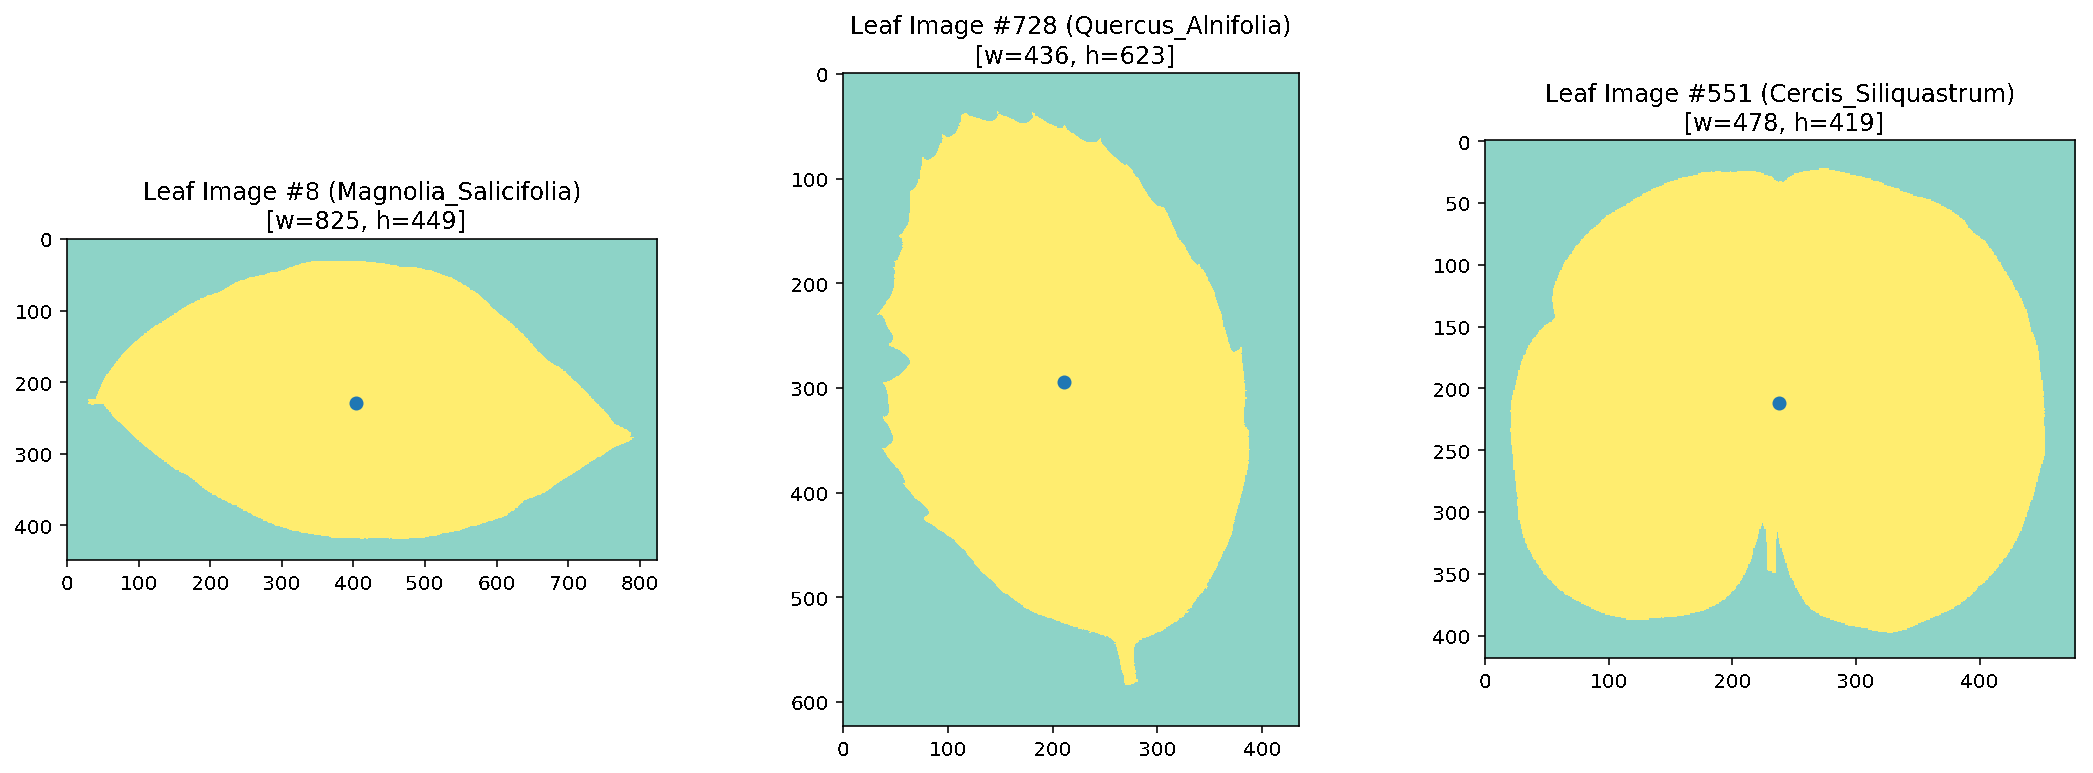

In [17]:
# draw the 3 sample leaf images
draw(SAMPLE_IDS, draw_image)

Pre-extracted Image Features


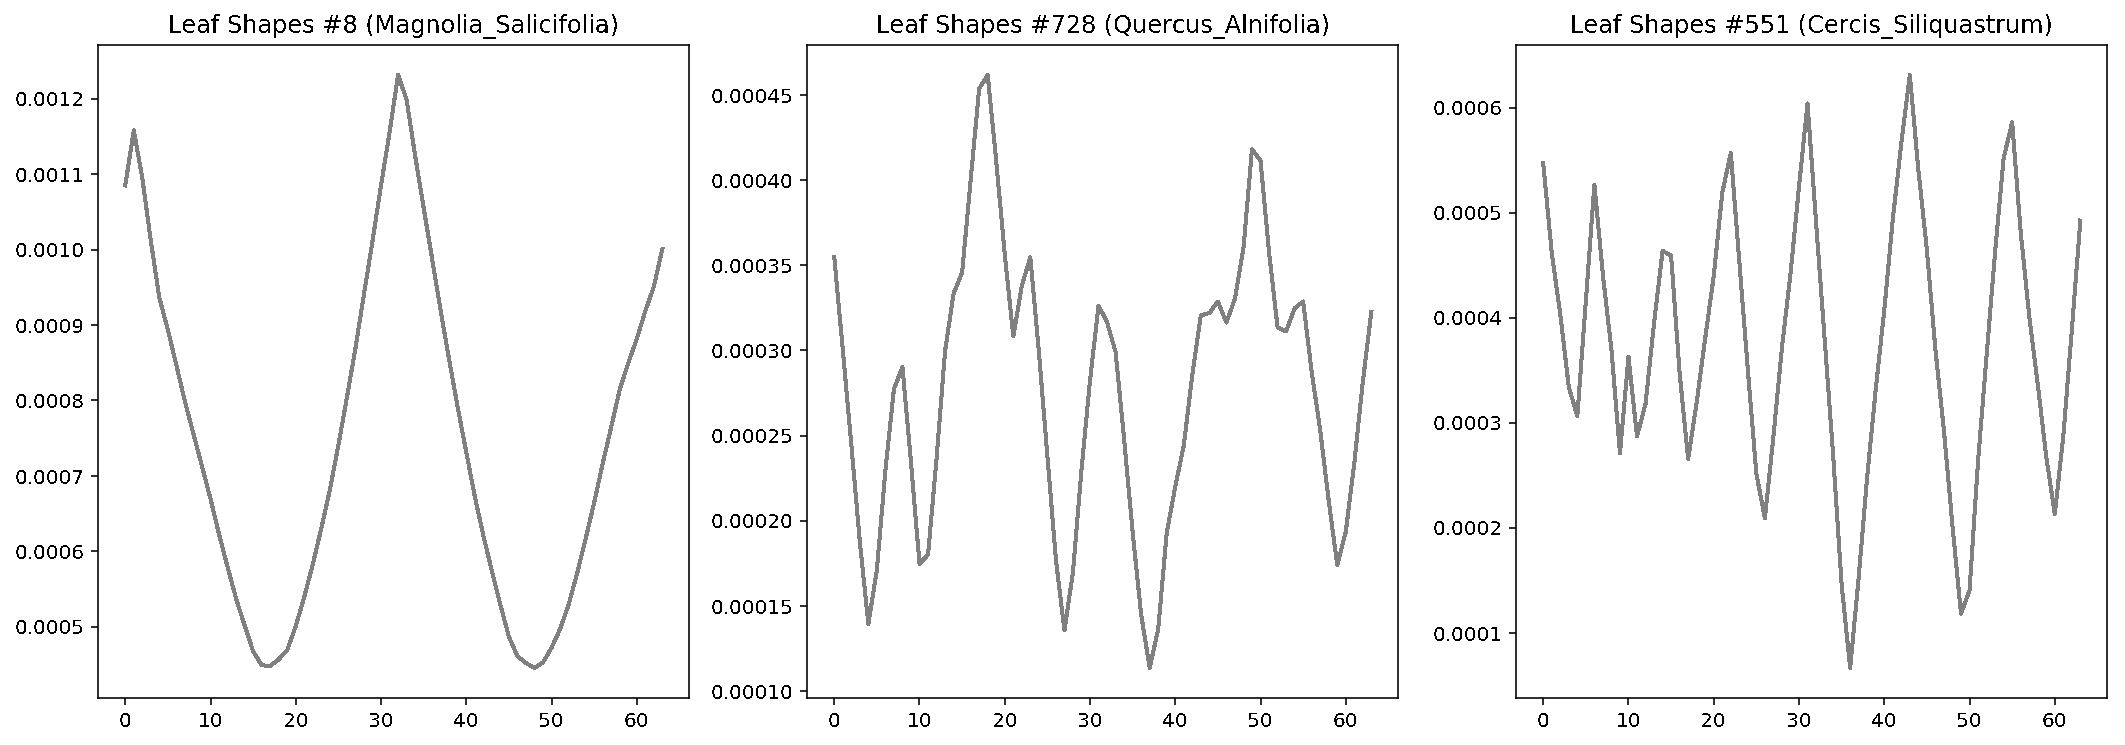

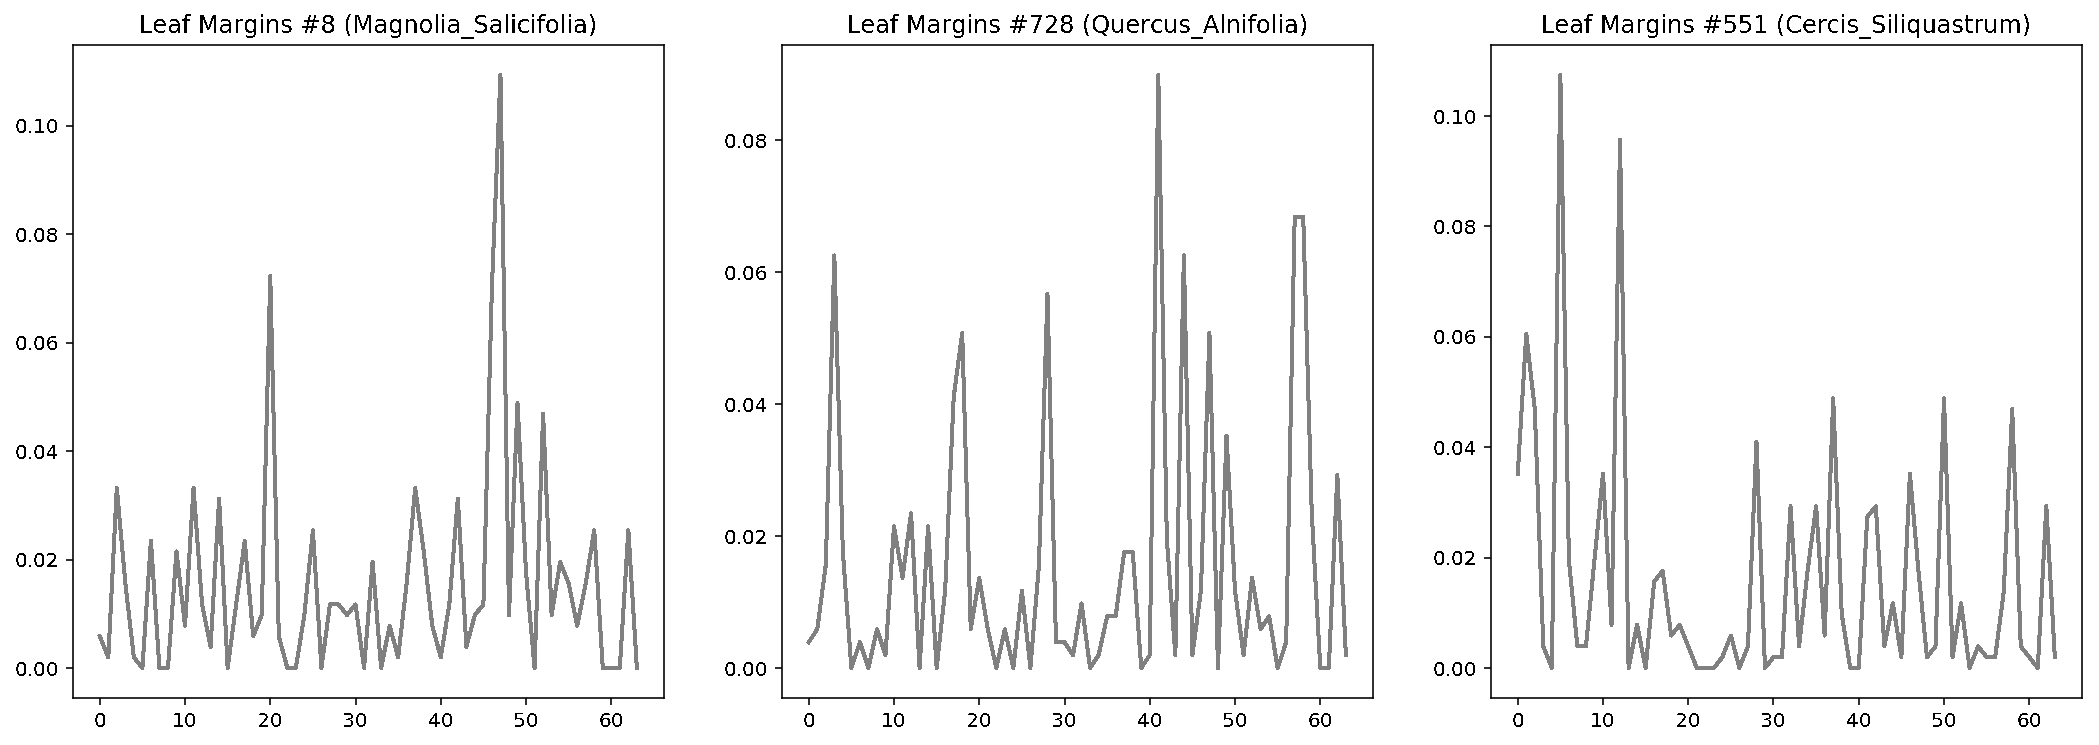

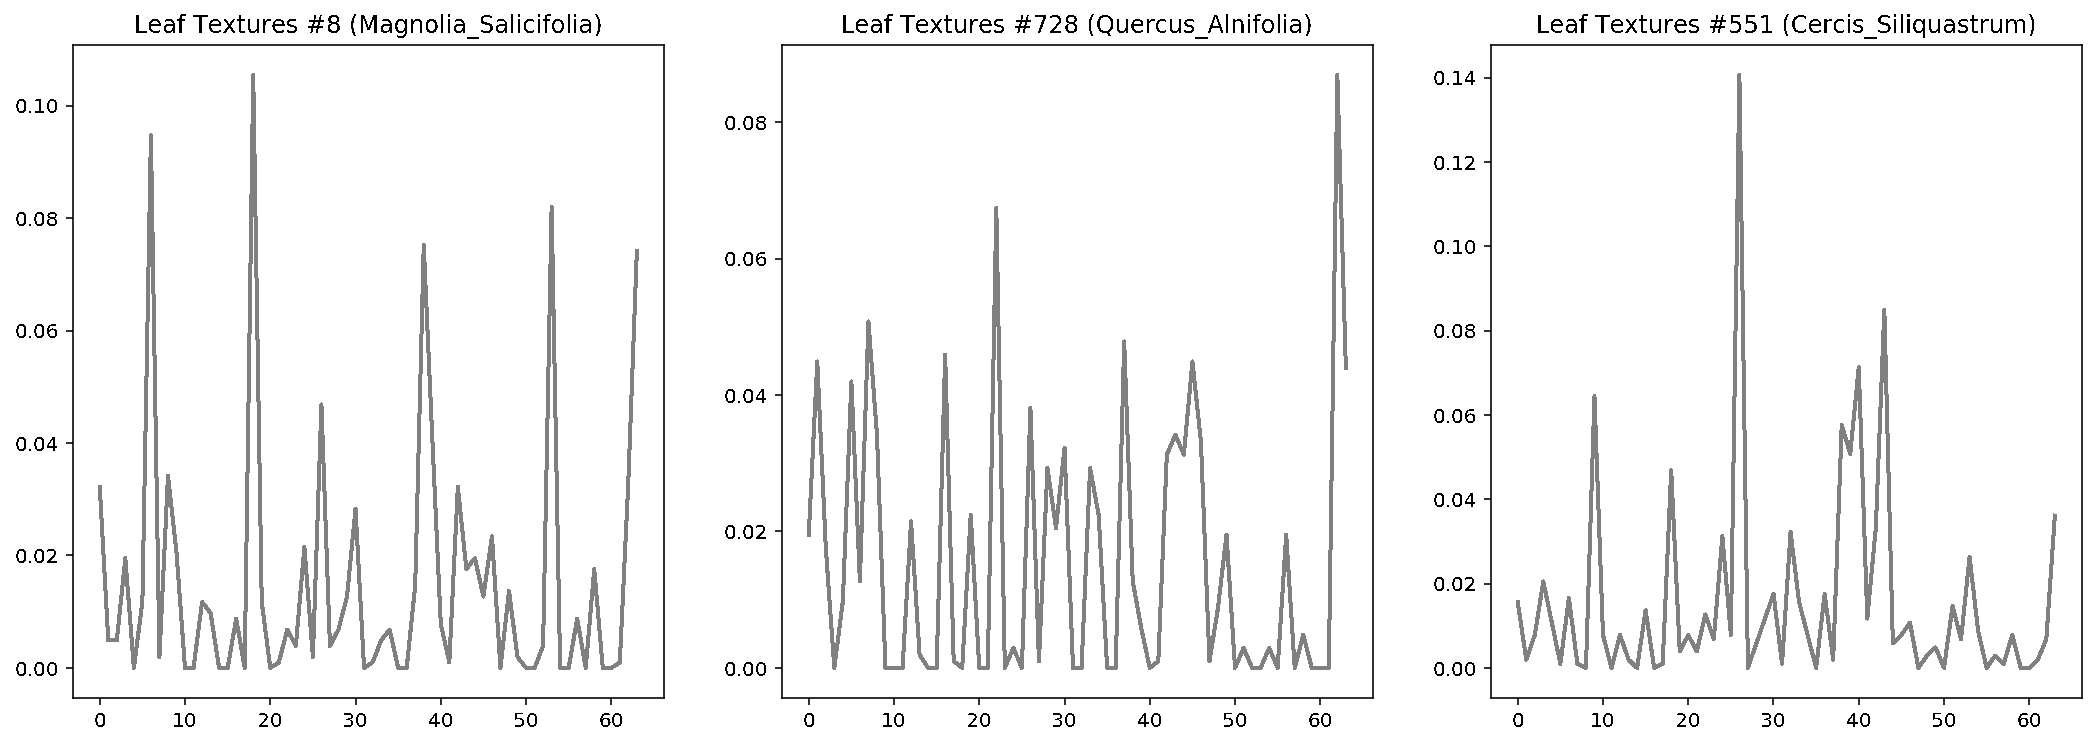

In [18]:
# draw pre-extracted image features
print('{0}\nPre-extracted Image Features\n{0}'.format('='*40))
# shapes: 1-d scaled lines)
draw(SAMPLE_IDS, draw_image_features_shapes)
draw(SAMPLE_IDS, draw_image_features_margins)
draw(SAMPLE_IDS, draw_image_features_textures)

In [19]:
# print image charateristics
for img_id in SAMPLE_IDS:
    img_features = extract_image_features(img_id)
    print('{0}\nLeaf: {1} (id={2})\n{0}'.format(
        '=' * 60,
        get_label_name_by_image_id(img_id), 
        img_id
    ))
    print('- number of image features: {}'. format(
        # substract 2 contour features
        len(img_features) - 2
    ))
    print('- image shape: w={}, h={}, size ratio={:.2f}'.format(
        img_features.width, 
        img_features.height,
        img_features.size_ratio
    ))
    print('- leaf shape: area={}, extent={:.2f}, perimeter={:.2f}'.format(
        img_features.area, 
        img_features.bextent,
        img_features.perimeter
    ))
    print('- extrema: #maxima={}, #minima={}, #teeth={}'.format(
        img_features.maxima.size, 
        img_features.minima.size, 
        img_features.teeth.size
    ))
    print('- centroid: cx={}, cy={}'.format(
        img_features.cx,
        img_features.cy
    ))
    print('- min rect: w={}, h={}, area={}'.format(
        img_features.rw,
        img_features.rh,
        img_features.rarea
    ))
    print('- orientation: horizontal={}, convex={}'.format(
        img_features.horizontal,
        img_features.convex
    ))
    print('- hull and extent: solidity={}, diameter={}, ellipse={}'.format(
        img_features.hextent,
        img_features.diameter,
        [img_features.ew, img_features.eh]
    ))

Leaf: Magnolia_Salicifolia (id=8)
- number of image features: 30
- image shape: w=825, h=449, size ratio=1.84
- leaf shape: area=195445.5, extent=0.66, perimeter=1880.28
- extrema: #maxima=2, #minima=3, #teeth=6
- centroid: cx=403.74, cy=228.97
- min rect: w=452.01, h=637.07, area=287963.85
- orientation: horizontal=1, convex=0.0
- hull and extent: solidity=0.99, diameter=498.85, ellipse=[369.54, 692.87]
Leaf: Quercus_Alnifolia (id=728)
- number of image features: 30
- image shape: w=436, h=623, size ratio=0.70
- leaf shape: area=130493.5, extent=0.67, perimeter=1680.80
- extrema: #maxima=3, #minima=4, #teeth=21
- centroid: cx=210.49, cy=293.96
- min rect: w=400.57, h=465.51, area=186471.7
- orientation: horizontal=0, convex=0.0
- hull and extent: solidity=0.95, diameter=407.61, ellipse=[327.75, 517.05]
Leaf: Cercis_Siliquastrum (id=551)
- number of image features: 30
- image shape: w=478, h=419, size ratio=1.14
- leaf shape: area=130485.0, extent=0.80, perimeter=1578.56
- extrema: #ma

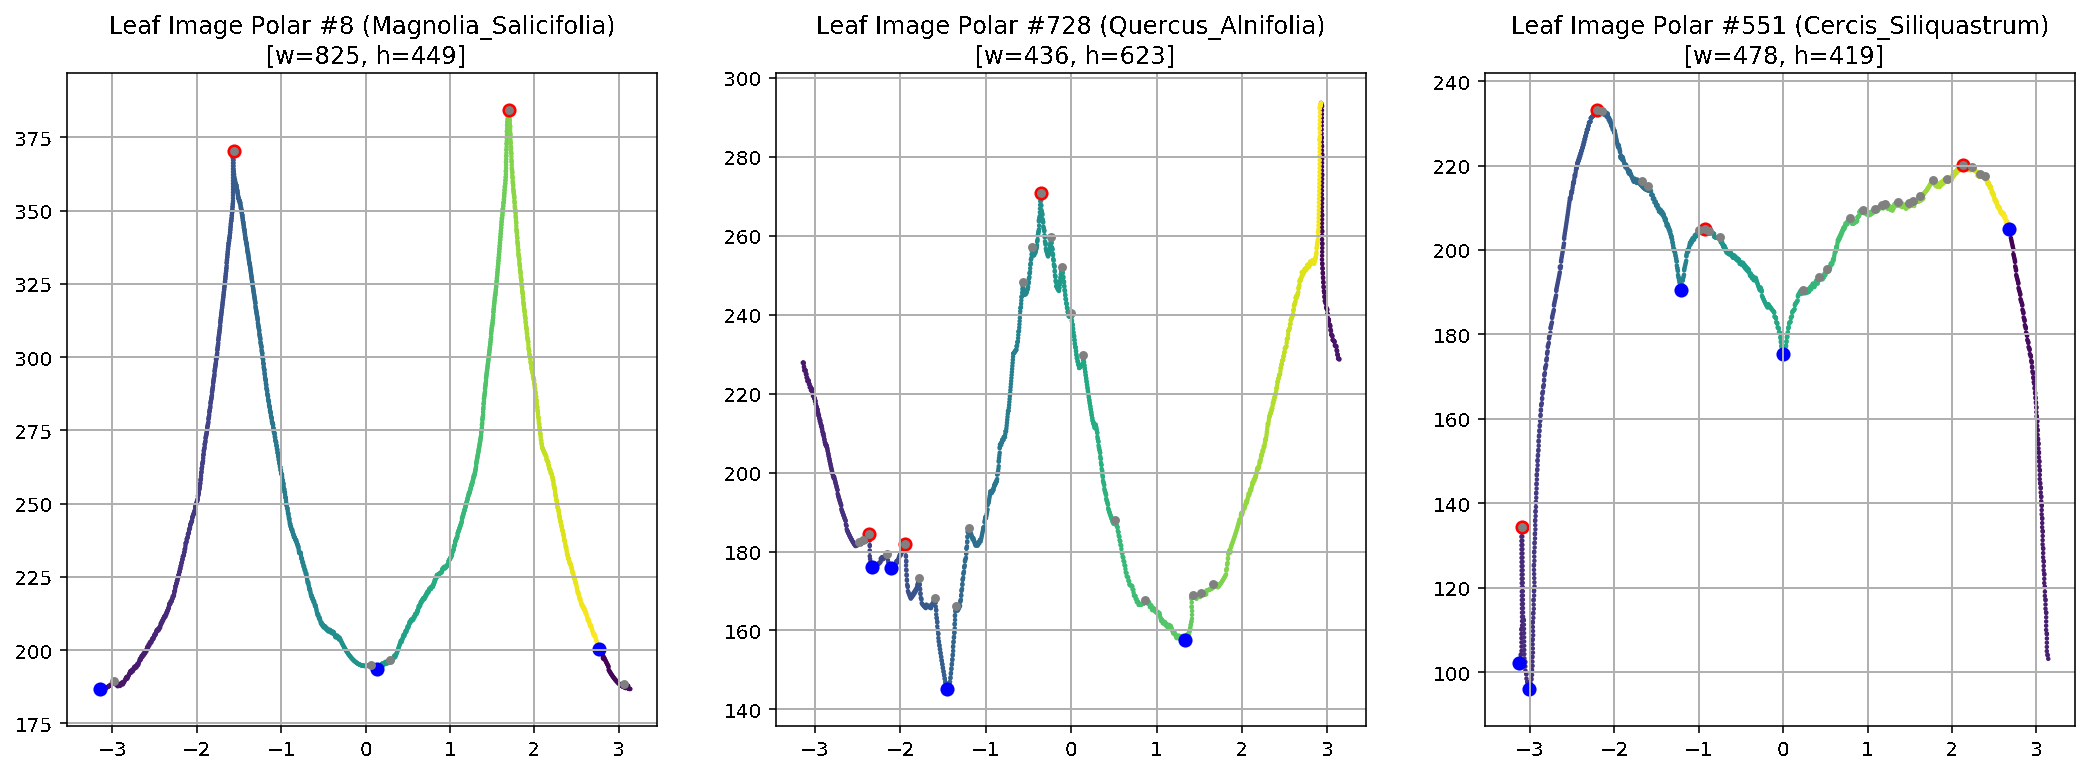

In [20]:
# draw polar contour of the sample image with extrema points
draw(SAMPLE_IDS, draw_polar_contour)

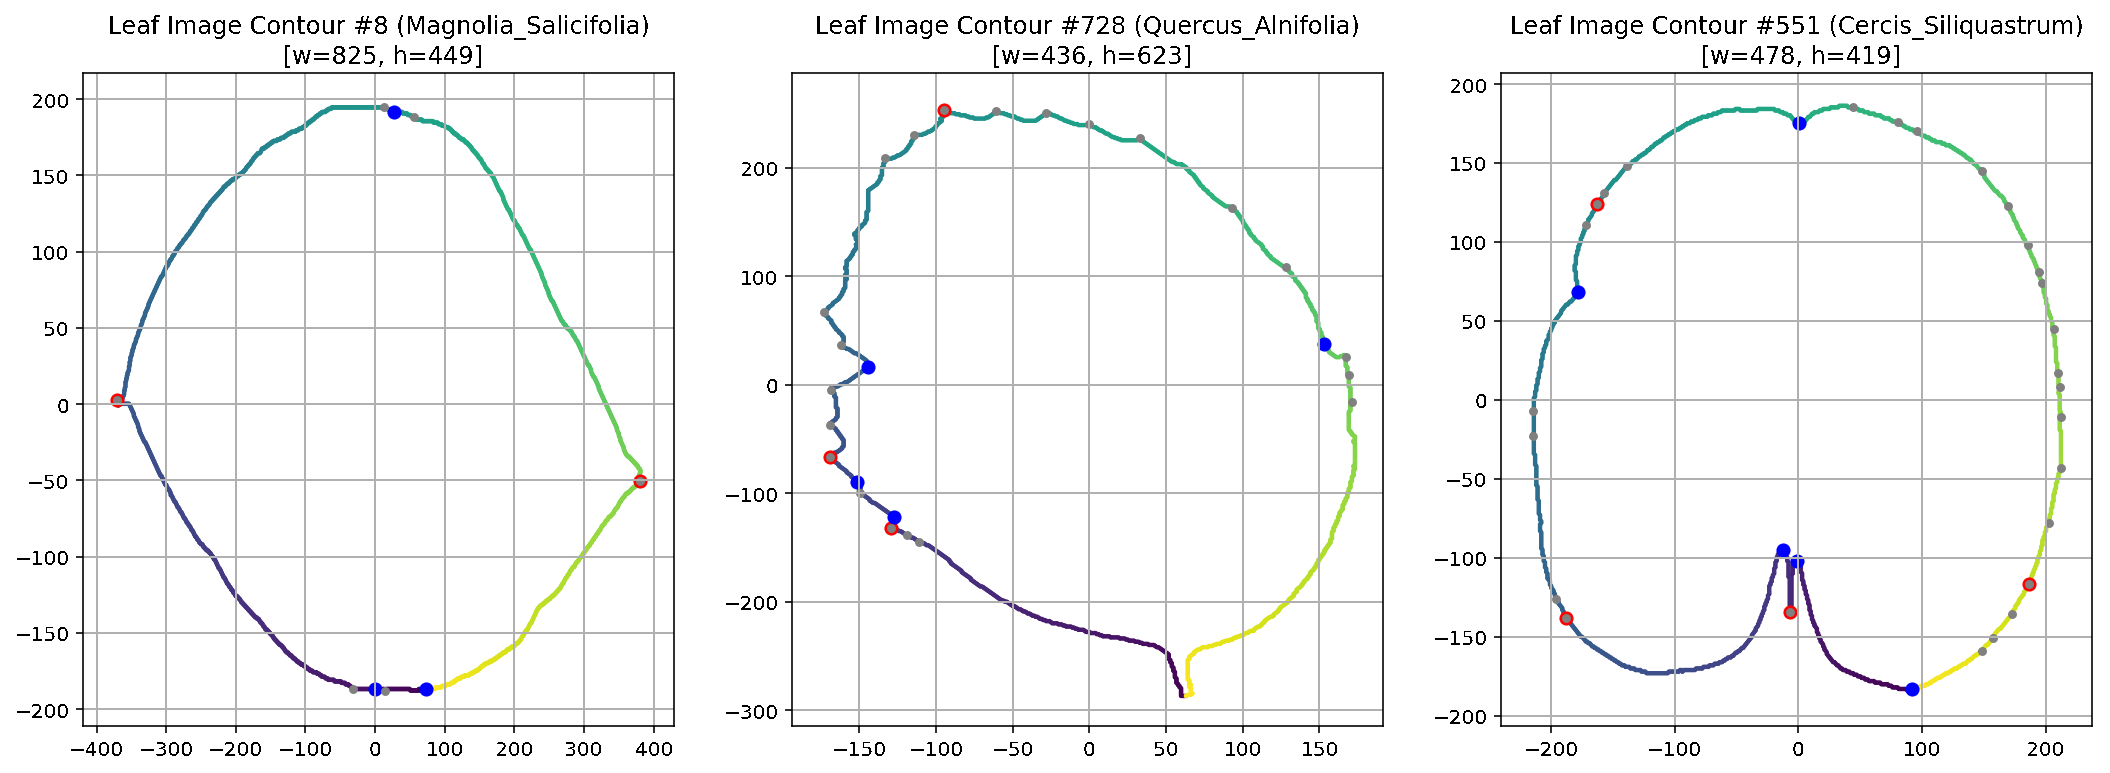

In [21]:
# draw cartesian contour of the sample image with extrema points
draw(SAMPLE_IDS, draw_contour)

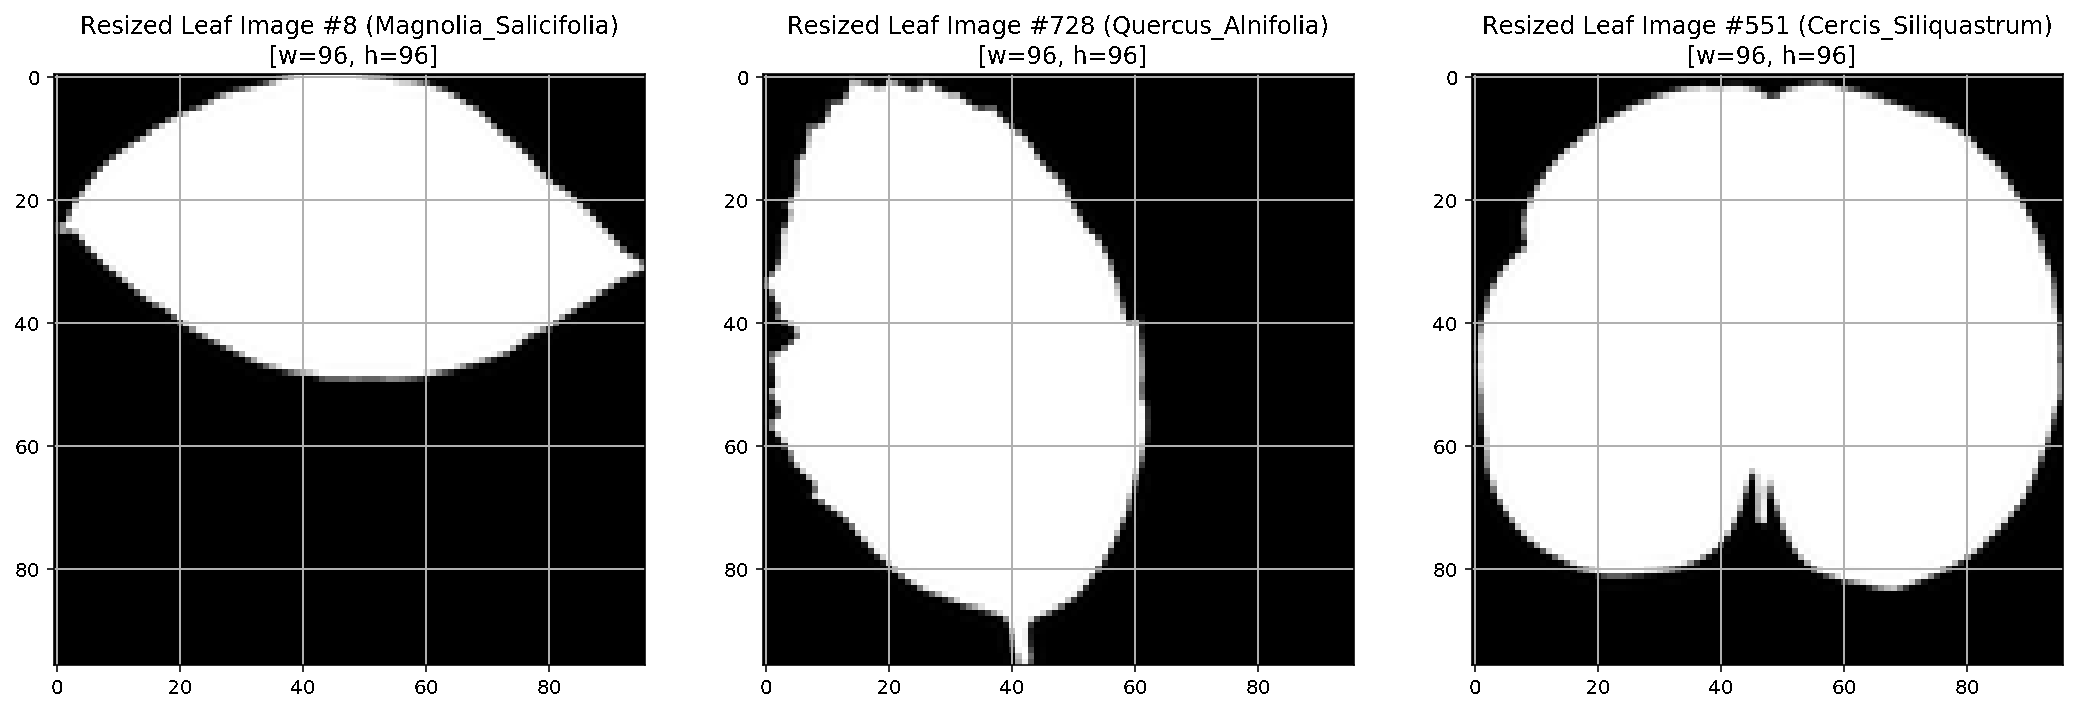

In [22]:
# draw resized image
draw(SAMPLE_IDS, draw_resized_image)

## Preprocess and Save

In [23]:
# preprocess and save training and test data
preprocess_and_save_data()

< preprocessing training data ...
> preprocessed 3960 samples
< preprocessing testing data ...
> preprocessed 594 samples
preprocess_and_save_data done.


### Preprocess Tests

In [24]:
# check preprocess outputs
test_preprocess_data()
# load the preprocess training data
train_pkl_path = '{}/preprocess_training.pkl'.format(DATA_DIR)
train_data = pickle.load(open(train_pkl_path, mode='rb'))
print('{} training samples loaded.'.format(len(train_data['images'])))
valid_data = get_validation_data(train_data)
print('{} validation samples loaded.'.format(len(valid_data['images'])))
# check split batch data
test_split_training_batch()

Test ok. All preprocess files found and validated.
7920 training samples loaded.
99 validation samples loaded.
> split batch tests ok.


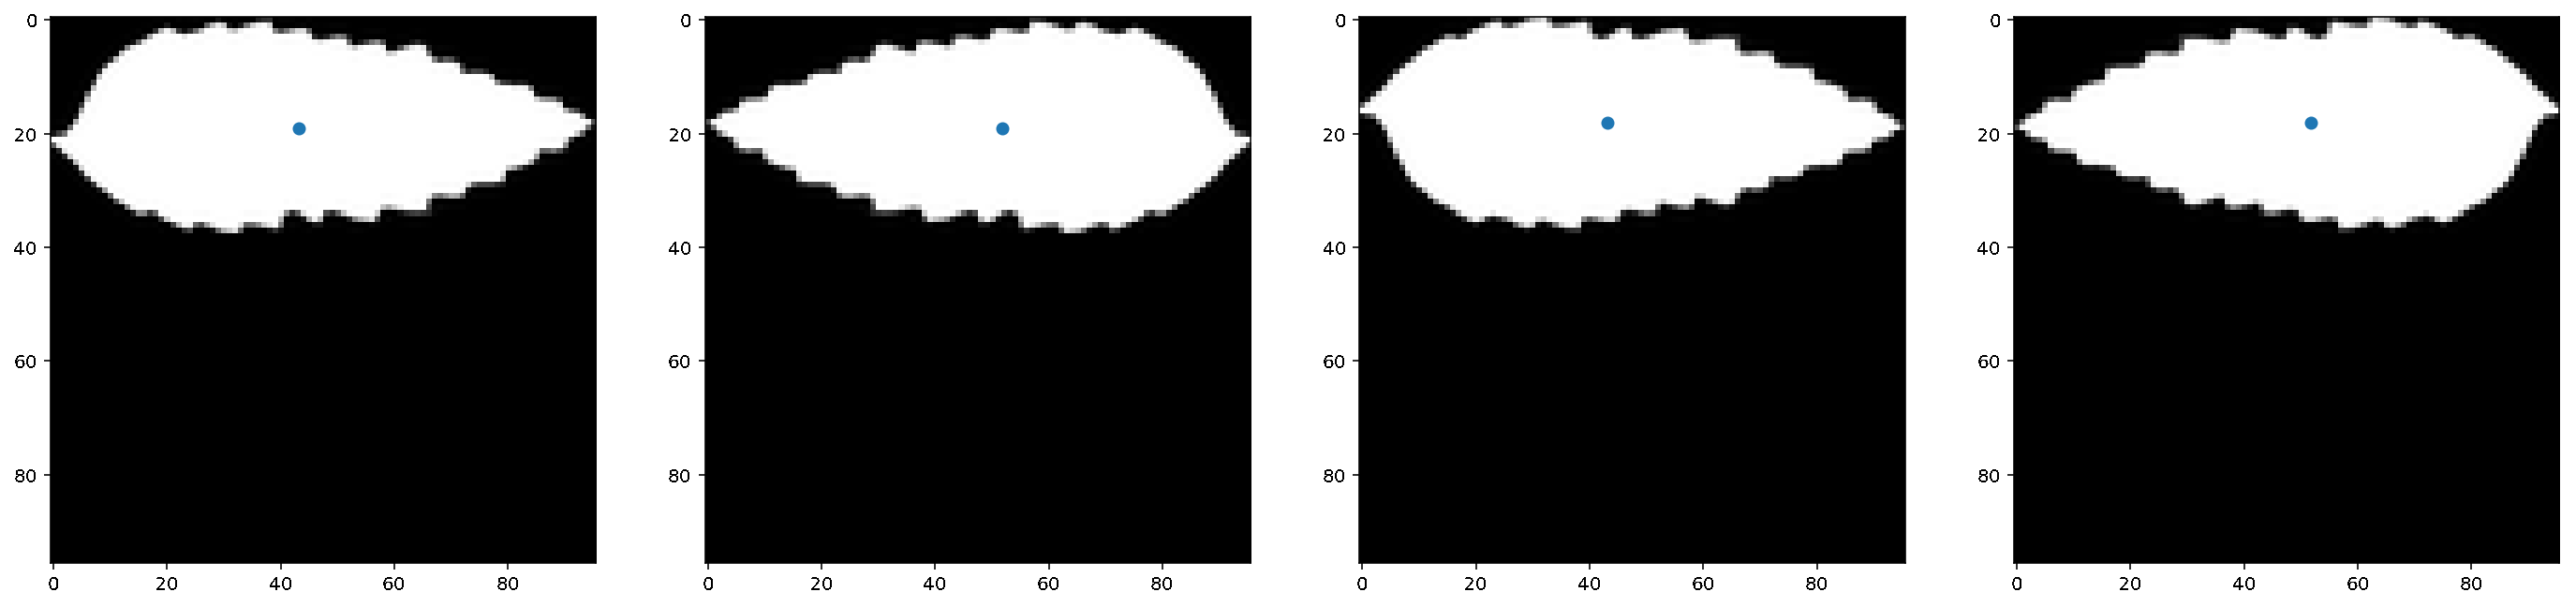

In [25]:
# check visually the generated resized images
img_id = SAMPLE_IDS[0]
n = train_df.shape[0]
img_ids = [img_id, img_id+n, img_id+n*2, img_id+n*3]
draw(img_ids, draw_train_image)

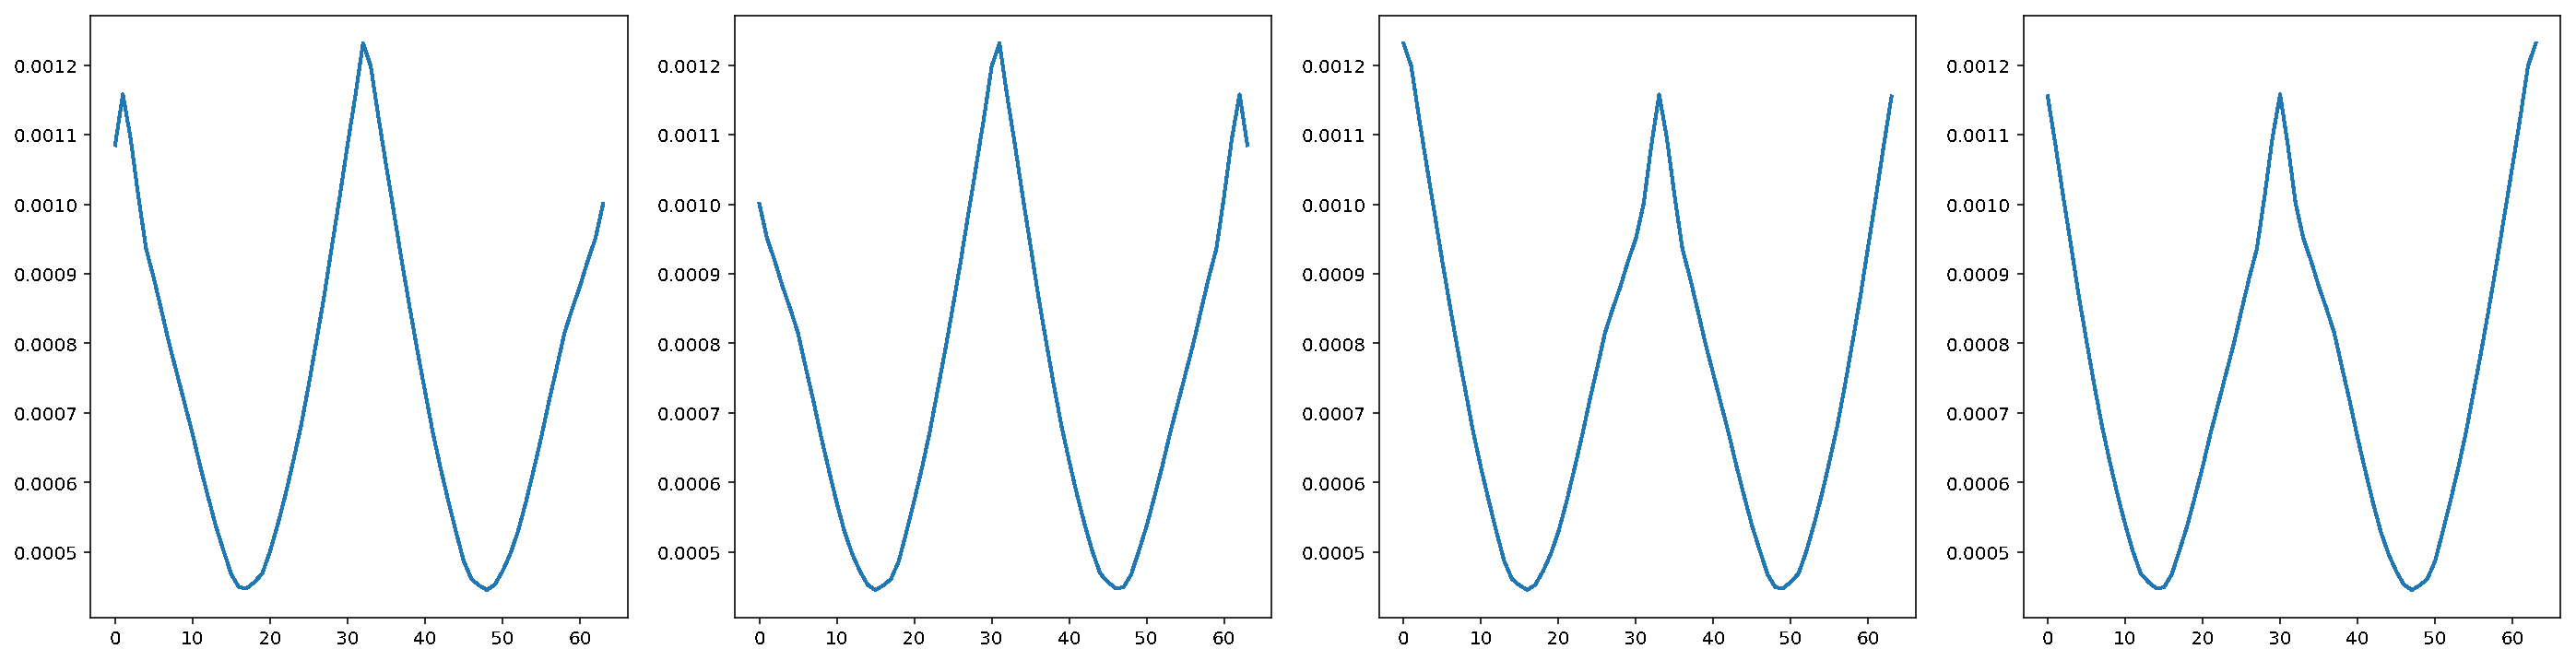

In [26]:
# check visually the generated shape lines
draw(img_ids, draw_train_line)

## Build Neural Network

In [27]:
# ======================================================
# convolutional 2d neural network and related
# ======================================================
def conv2d_layer(
    X, 
    n_outputs,
    ksize,
    strides,
    pool_ksize, 
    pool_strides
):
    """
    Apply convolution then max pooling to X
    :param X: TensorFlow Tensor
    :param n_outputs: Number of outputs for the convolutional layer
    :param ksize: kernel (patch) size 2-D Tuple for the convolutional layer
    :param strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of X
    """
    # ----------------------------
    # prepares trainalbe variables
    # -----------------------------
    # (patch height, patch width, input channel size, output channel size)
    # e.g. 6*6 patch, 1 input channel, 128 output channels
    conv_shape = (*ksize, X.shape[3].value, n_outputs)    
    weights = tf.Variable(tf.truncated_normal(conv_shape, stddev=.1))
    # creates 2d convolution layer
    X_conv = tf.nn.conv2d(X, weights, strides=[1, *strides, 1], padding='SAME')
    
    bias = tf.Variable(tf.constant(0.1, tf.float32, [n_outputs]))
    X_conv = tf.nn.bias_add(X_conv, bias)
    # batch normalization
    X_conv = tf.contrib.layers.batch_norm(
        X_conv
    )
    # relu activation
    X_conv = tf.nn.relu(X_conv)
    # creates max pool layer
    X_conv = tf.nn.max_pool(
        X_conv, 
        ksize=[1, *pool_ksize, 1], 
        strides=[1, *pool_strides, 1], 
        padding='SAME'
    )
    return X_conv

def conv2d_net(X):
    """
    Create a convolutional 2d neural network model
    : X: Placeholder tensor that holds image data
    : return: Tensor that represents logits
    """
    # Apply three convolution and max pool layers
    n_outputs = [16,4]
    ksizes = [(8,8),(4,4)]
    strides = [(3,3),(1,1)]
    pool_ksizes = [(4,4),(3,3)]
    pool_strides = [(6,6),(2,2)]
    
    # builds convolution and max pool layers
    X_conv2d = X
    for i in range(len(n_outputs)):
        # hidden clayers
        X_conv2d = conv2d_layer(
            X_conv2d,
            n_outputs[i],
            ksizes[i],
            strides[i],
            pool_ksizes[i],
            pool_strides[i]
        )
    # flatten X_conv to flattened image size
    X_conv2d = tf.contrib.layers.flatten(X_conv2d)
    print('conv2d-net:\n\t= (images->tx->bn->relu->maxpool)[{}]->flatten'.format(
        len(n_outputs)
    ))
    print('\t< X: {}\n\t> X_conv2d: {}'.format(
        X.shape,
        X_conv2d.shape
    ))
    return X_conv2d


In [28]:
# ======================================================
# convolutional 1d neural network and related
# ======================================================
def conv1d_layer(
    X, 
    n_outputs,
    ksize,
    stride
):
    """
    Apply convolution then max pooling to X
    :param X: TensorFlow Tensor
    :param n_outputs: Number of outputs for the convolutional layer
    :param ksize: kernel (patch) size for the convolutional layer
    :param stride: Stride for convolution
    : return: A tensor that represents convolution and max pooling of X
    """
    # ----------------------------
    # prepares trainalbe variables
    # -----------------------------
    conv_shape = (ksize, X.shape[2].value, n_outputs)
    weights = tf.Variable(tf.truncated_normal(conv_shape, stddev=.1))
    X_conv = tf.nn.conv1d(X, weights, stride=stride, padding="SAME")

    bias = tf.Variable(tf.constant(0.1, tf.float32, [n_outputs]))
    X_conv = tf.nn.bias_add(X_conv, bias)
    # batch normalization
    X_conv = tf.contrib.layers.batch_norm(
        X_conv
    )    
    # relu activation
    X_conv = tf.nn.relu(X_conv)
    return X_conv

def conv1d_net(X):
    """
    Create a convolutional 1d neural network model
    : X: Placeholder tensor that holds image data
    : return: Tensor that represents logits
    """
    # Apply three convolution and max pool layers
    n_outputs = (24,12)    
    ksizes = (12,6)
    strides = (4,4)
    
    # builds convolution
    X_conv1d = X
    for i in range(len(n_outputs)):
        # hidden clayers
        X_conv1d = conv1d_layer(
            X_conv1d,
            n_outputs[i],
            ksizes[i],
            strides[i]
        )
    # flatten X_conv to flattened image size
    X_conv1d = tf.contrib.layers.flatten(X_conv1d)
    print('conv1d-net:\n\t= (lines->tx->bn->relu)[{}]->flatten'.format(
        len(n_outputs)
    ))
    print('\t< X: {}\n\t> X_conv1d: {}'.format(
        X.shape,
        X_conv1d.shape
    ))
    return X_conv1d

In [29]:
# ==========================
# features fnn related
# ==========================
def prepare_features_fnn(Xs):
    """
    merge different features sources and batch-norm them
    """
    X_features = tf.concat(Xs, 1, name='X_features')
    X_features = tf.contrib.layers.batch_norm(
        X_features,
        center=True,
        scale=True
    ) 
    print('fnn-net:\n\t= features->bn')
    print('\t< #sources: {}\n\t> X_features: {}'.format(
        len(Xs),
        X_features.shape
    ))
    return X_features

In [30]:
# ==================================
# fully connected related
# ==================================
def fully_connected(X_inputs, pkeep):
    """
    create fully connected cnn + dl layers
    """
    # join cnn + dl results
    X = tf.concat(axis=1, values=[*X_inputs])   
    n_classes = get_num_classes()
    n_outputs = [n_classes, n_classes*2, n_classes]
    fc_shape = (n_outputs[-1], n_classes)
    weights = tf.Variable(tf.truncated_normal(fc_shape, stddev=.1))
    bias = tf.Variable(tf.constant(.01, tf.float32, [fc_shape[0]]))
    X_fc = X
    for i in range(len(n_outputs)):
        # apply a fully connected layer to x_tensor using weight and bias
        X_fc = tf.contrib.layers.fully_connected(
            X_fc,
            num_outputs=n_outputs[i]
        )
        # apply batchnorm, relu activation and dropout functions
        X_fc = tf.contrib.layers.batch_norm(
            X_fc,
            center=True,
            scale=True
        )
        X_fc = tf.nn.relu(X_fc)
        X_fc = tf.nn.dropout(X_fc, pkeep)
    
    # (full connected output size, softmax output size)
    X_fc = tf.add(tf.matmul(X_fc, weights), bias)
    print('fully-connected:\n\t= (Xs->bn->relu->[drop])[{}]->mtx'.format(
        len(n_outputs)
    ))
    print('\t< X: {}\n\t> X_fc: {}'.format(
        X.shape,
        X_fc.shape
    ))    
    return X_fc

In [31]:
# =========================================
# build + train the final neural network
# =========================================
def print_stats(session, logloss, xentropy, accuracy, lr, train_feed, valid_feed):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    train_logloss = session.run(
        logloss,
        feed_dict=train_feed
    )
    train_xentropy = session.run(
        xentropy,
        feed_dict=train_feed
    )
    train_acc = session.run(
        accuracy,
        feed_dict=train_feed
    )
    valid_logloss = session.run(
        logloss,
        feed_dict=valid_feed
    )
    valid_xentropy = session.run(
        xentropy,
        feed_dict=valid_feed
    )
    valid_acc = session.run(
        accuracy,
        feed_dict=valid_feed
    )
    print('logloss: t={:.6f}, v={:.6f}, '.format(
        train_logloss,
        valid_logloss
    ) + 'xentropy: t={:.6f}, v={:.6f}, '.format(
        train_xentropy,
        valid_xentropy
    ) + 'accuracy: t={:.6f}, v={:.6f}, lr={:.6f}'.format(
        train_acc,
        valid_acc,
        lr
    ))

def get_learning_rate(batch_id):
    """
    calculate learning rate decay by batch number
    """
    lr = MIN_LEARNING_RATE + (
        (MAX_LEARNING_RATE - MIN_LEARNING_RATE) *
        math.exp(-batch_id/LEARNING_RATE_DECAY_SPEED)
    )
    return lr

def save_model(session, save_model_path = './model/model'):
    """
    saves the current model to disk
    """
    print('Saving model to disk ...')
    saver = tf.train.Saver()
    save_path = saver.save(session, save_model_path)
    
def run_neural_network():
    """
    try to train with all batches.
    """
    

    # clean up previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    print('Building TF Graph ...')
    # input X: 64x64 grayscale images, 
    # the first dimension (None) will index the images in the mini-batch
    X_images_pl = tf.placeholder(
        tf.float32, 
        [None, *CONV2D_SHAPE], 
        name='X_images'
    )
    X_lines_pl = tf.placeholder(
        tf.float32, 
        [None, *CONV1D_SHAPE], 
        name='X_lines'
    )
    X_features_extra_pl = tf.placeholder(
        tf.float32, 
        [None, N_FEATURES_EXTRA], 
        name='X_features_extra'
    )
    X_features_margins_pl = tf.placeholder(
        tf.float32, 
        [None, CONV1D_SHAPE[0]], 
        name='X_features_margins'
    )
    X_features_textures_pl = tf.placeholder(
        tf.float32, 
        [None, CONV1D_SHAPE[0]], 
        name='X_features_textures'
    )
    X_features_shapes_pl = tf.placeholder(
        tf.float32, 
        [None, CONV1D_SHAPE[0]], 
        name='X_features_shapes'
    )
    # correct answers will go here
    Y_pl = tf.placeholder(
        tf.float32, 
        [None, get_num_classes()], 
        name='Y'
    )
    # dropout probability
    pkeep_pl = tf.placeholder(tf.float32, name='pkeep')
    # variable learning rate
    lr_pl = tf.placeholder(tf.float32, name='lr')
    
    # initialize values
    step = 1
    lr = get_learning_rate(step)
    pkeep = KEEP_PROBABILITY

    # build model
    X_images = conv2d_net(X_images_pl)
    X_lines = conv1d_net(X_lines_pl)
    X_features = prepare_features_fnn([
        X_features_extra_pl,
        X_features_textures_pl,
        X_features_margins_pl,
        X_features_shapes_pl
    ])
    print('< cnn2d images shape: {}'.format(X_images.shape))
    print('< cnn1d lines shape: {}'.format(X_lines.shape))
    print('< fnn features shape: {}'.format(X_features.shape))
    #logits = fully_connected([X_images, X_lines, X_features], pkeep_pl)
    logits = fully_connected([X_lines, X_features], pkeep_pl)
    logits = tf.identity(logits, name='logits')
    xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, 
        labels=Y_pl
    ))
    logloss = tf.reduce_mean(tf.losses.log_loss(
        predictions=tf.nn.softmax(logits), 
        labels=Y_pl
    ))
    optimizer = tf.train.AdamOptimizer(lr).minimize(logloss)
    print('optimizer:\n\t= logits->softmax->loss->adam optimizer')

    # accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_pl, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    print('Training...')
    with tf.Session() as session:
        # Initializing the variables
        session.run(tf.global_variables_initializer())        
        batch_size = get_batch_size()
        print('< #epochs: {}'.format(N_EPOCHS))
        print('< #batches: {} (à {} samples)'.format(
            N_BATCHES, 
            batch_size
        ))
        print('< initial lr: {:.6f}'.format(lr))
        print('< keep probability: {}'.format(pkeep))
        print('TF variables initalized...')
        
        start = timer()
        # Training cycle
        for epoch in range(N_EPOCHS):            
            # Loop over all batches
            for batch_i in range(N_BATCHES):
                lr = get_learning_rate(step)
                batch_data = split_training_data(batch_i, train_data)
                train_feed = {
                    X_features_extra_pl: batch_data['features_extra'],
                    X_features_margins_pl: batch_data['features_margins'],
                    X_features_textures_pl: batch_data['features_textures'],
                    X_features_shapes_pl: batch_data['features_shapes'],
                    X_lines_pl: batch_data['lines'],
                    X_images_pl: batch_data['images'],
                    Y_pl: batch_data['labels'],
                    pkeep_pl: pkeep,
                    lr_pl: lr
                }
                # optimize the session on a batch of images and labels
                session.run(
                    optimizer,
                    feed_dict=train_feed
                )
                # print stats every 10 epochs
                if step % (N_BATCHES * 10) == 0:
                    print('[{:.2f}s] #{} ep-{}: '.format(
                        timer()-start,
                        step,
                        epoch+1
                    ), end='')
                    start = timer()
                    train_feed[pkeep_pl] = 1.0
                    valid_feed = {
                        X_features_extra_pl: valid_data['features_extra'],
                        X_features_margins_pl: valid_data['features_margins'],
                        X_features_textures_pl: valid_data['features_textures'],
                        X_features_shapes_pl: valid_data['features_shapes'],
                        X_lines_pl: valid_data['lines'],
                        X_images_pl: valid_data['images'],
                        Y_pl: valid_data['labels'],
                        pkeep_pl: 1.0
                    }
                    print_stats(
                        session, logloss, xentropy, accuracy, lr, 
                        train_feed, valid_feed
                    )
                # save model every 500 epochs
                if step % (N_BATCHES * 500) == 0:
                    save_model(session)
                step += 1
            np.random.shuffle(batch_selector)
        save_model(session)
    print('Training done.')

## Train Model

In [32]:
run_neural_network()

Building TF Graph ...
conv2d-net:
	= (images->tx->bn->relu->maxpool)[2]->flatten
	< X: (?, 96, 96, 1)
	> X_conv2d: (?, 36)
conv1d-net:
	= (lines->tx->bn->relu)[2]->flatten
	< X: (?, 64, 1)
	> X_conv1d: (?, 48)
fnn-net:
	= features->bn
	< #sources: 4
	> X_features: (?, 222)
< cnn2d images shape: (?, 36)
< cnn1d lines shape: (?, 48)
< fnn features shape: (?, 222)
fully-connected:
	= (Xs->bn->relu->[drop])[3]->mtx
	< X: (?, 270)
	> X_fc: (?, 99)
optimizer:
	= logits->softmax->loss->adam optimizer
Training...
< #epochs: 10000
< #batches: 10 (à 396 samples)
< initial lr: 0.001000
< keep probability: 0.9
TF variables initalized...
[26.59s] #100 ep-10: logloss: t=0.000953, v=0.001029, xentropy: t=0.048117, v=0.051845, accuracy: t=1.000000, v=1.000000, lr=0.000999
[34.99s] #200 ep-20: logloss: t=0.000168, v=0.000225, xentropy: t=0.008321, v=0.011182, accuracy: t=1.000000, v=1.000000, lr=0.000998
[37.77s] #300 ep-30: logloss: t=0.000067, v=0.000094, xentropy: t=0.003337, v=0.004652, accuracy: t

[13.12s] #5700 ep-570: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000002, v=0.000003, accuracy: t=1.000000, v=1.000000, lr=0.000945
[12.63s] #5800 ep-580: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000001, v=0.000003, accuracy: t=1.000000, v=1.000000, lr=0.000944
[13.59s] #5900 ep-590: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000002, v=0.000003, accuracy: t=1.000000, v=1.000000, lr=0.000943
[13.40s] #6000 ep-600: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000002, v=0.000003, accuracy: t=1.000000, v=1.000000, lr=0.000942
[12.83s] #6100 ep-610: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000001, v=0.000002, accuracy: t=1.000000, v=1.000000, lr=0.000941
[12.94s] #6200 ep-620: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000002, v=0.000003, accuracy: t=1.000000, v=1.000000, lr=0.000940
[13.05s] #6300 ep-630: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000001, v=0.000002, accuracy: t=1.000000, v=1.000000, lr=0.000940
[13.37s] #6400 ep-640: logloss: t=

[14.66s] #17500 ep-1750: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000841
[14.88s] #17600 ep-1760: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000840
[14.36s] #17700 ep-1770: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000839
[14.62s] #17800 ep-1780: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000839
[14.23s] #17900 ep-1790: logloss: t=0.000000, v=0.000025, xentropy: t=0.000010, v=0.001261, accuracy: t=1.000000, v=1.000000, lr=0.000838
[14.79s] #18000 ep-1800: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000002, accuracy: t=1.000000, v=1.000000, lr=0.000837
[14.33s] #18100 ep-1810: logloss: t=-0.000000, v=0.000000, xentropy: t=0.000000, v=0.000007, accuracy: t=1.000000, v=1.000000, lr=0.000836
[15.75s] #18200 ep-1820

[51.01s] #23400 ep-2340: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000793
[41.61s] #23500 ep-2350: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000793
[40.59s] #23600 ep-2360: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000792
[41.92s] #23700 ep-2370: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000791
[41.21s] #23800 ep-2380: logloss: t=-0.000000, v=0.000003, xentropy: t=0.000002, v=0.000159, accuracy: t=1.000000, v=1.000000, lr=0.000790
[35.70s] #23900 ep-2390: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000790
[37.90s] #24000 ep-2400: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000001, accuracy: t=1.000000, v=1.000000, lr=0.000789
[38.93s] #24100 ep-24

[15.26s] #29300 ep-2930: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000749
[16.14s] #29400 ep-2940: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000748
[15.58s] #29500 ep-2950: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000747
[15.26s] #29600 ep-2960: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000746
[15.48s] #29700 ep-2970: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000746
[15.52s] #29800 ep-2980: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000745
[15.28s] #29900 ep-2990: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000744
[15.43s] #30000 ep-3

[17.81s] #41000 ep-4100: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000667
[18.00s] #41100 ep-4110: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000666
[16.37s] #41200 ep-4120: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000666
[19.10s] #41300 ep-4130: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000665
[18.25s] #41400 ep-4140: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000664
[16.21s] #41500 ep-4150: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000664
[15.64s] #41600 ep-4160: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000663
[15.37s] #41700 ep-4

[15.03s] #46900 ep-4690: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000629
[14.65s] #47000 ep-4700: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000629
[14.75s] #47100 ep-4710: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000628
[15.20s] #47200 ep-4720: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000628
[15.54s] #47300 ep-4730: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000627
[14.58s] #47400 ep-4740: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000626
[15.14s] #47500 ep-4750: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000626
[15.42s] #47600 ep-4

[15.83s] #52800 ep-5280: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000594
[21.53s] #52900 ep-5290: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000593
[37.23s] #53000 ep-5300: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000593
[37.48s] #53100 ep-5310: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000592
[40.43s] #53200 ep-5320: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000592
[38.63s] #53300 ep-5330: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000591
[37.54s] #53400 ep-5340: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000590
[47.96s] #53500 ep-5

[33.84s] #58700 ep-5870: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000560
[34.16s] #58800 ep-5880: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000560
[46.02s] #58900 ep-5890: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000559
[42.74s] #59000 ep-5900: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000559
[37.92s] #59100 ep-5910: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000558
[33.28s] #59200 ep-5920: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000002, accuracy: t=1.000000, v=1.000000, lr=0.000558
[44.15s] #59300 ep-5930: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000557
[40.48s] #59400 ep-5

[14.32s] #64600 ep-6460: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000529
[13.86s] #64700 ep-6470: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000528
[13.95s] #64800 ep-6480: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000528
[14.16s] #64900 ep-6490: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000527
[13.72s] #65000 ep-6500: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000527
Saving model to disk ...
[20.29s] #65100 ep-6510: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000526
[14.20s] #65200 ep-6520: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.00

[50.00s] #76300 ep-7630: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000472
[47.32s] #76400 ep-7640: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000471
[42.16s] #76500 ep-7650: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000471
[41.99s] #76600 ep-7660: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000470
[43.26s] #76700 ep-7670: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000470
[40.14s] #76800 ep-7680: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000469
[36.41s] #76900 ep-7690: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000469
[40.94s] #77000 ep-7

[41.96s] #82200 ep-8220: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000445
[54.66s] #82300 ep-8230: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000445
[54.40s] #82400 ep-8240: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000444
[50.48s] #82500 ep-8250: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000444
[38.13s] #82600 ep-8260: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000443
[38.51s] #82700 ep-8270: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000443
[37.93s] #82800 ep-8280: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000443
[37.50s] #82900 ep-8

[61.59s] #88100 ep-8810: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000420
[40.45s] #88200 ep-8820: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000420
[41.69s] #88300 ep-8830: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000419
[38.84s] #88400 ep-8840: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000419
[40.03s] #88500 ep-8850: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000419
[38.29s] #88600 ep-8860: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000418
[37.21s] #88700 ep-8870: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000418
[37.30s] #88800 ep-8

[42.94s] #94000 ep-9400: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000397
[38.41s] #94100 ep-9410: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000396
[37.71s] #94200 ep-9420: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000396
[37.43s] #94300 ep-9430: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000396
[40.68s] #94400 ep-9440: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000395
[38.14s] #94500 ep-9450: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000395
[36.18s] #94600 ep-9460: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000394
[40.13s] #94700 ep-9

[15.44s] #99900 ep-9990: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000375
[15.14s] #100000 ep-10000: logloss: t=-0.000000, v=-0.000000, xentropy: t=0.000000, v=0.000000, accuracy: t=1.000000, v=1.000000, lr=0.000374
Saving model to disk ...
Saving model to disk ...
Training done.


## Test Model

In [33]:
# =========================================================
# create competition submission file for onsite validation
# =========================================================

def create_submission():
    """
    create the final submission csv using the saved model
    """
    save_model_path = './model/model'
    test_pkl_path = '{}/preprocess_testing.pkl'.format(DATA_DIR)
    test_data = pickle.load(open(test_pkl_path, mode='rb'))
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as session:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(session, save_model_path)

        # Get Tensors from loaded model
        logits_fn = loaded_graph.get_tensor_by_name('logits:0')
        Y_fn = tf.nn.softmax(logits_fn)
        X_images_pl = loaded_graph.get_tensor_by_name('X_images:0')
        X_lines_pl = loaded_graph.get_tensor_by_name('X_lines:0')
        X_features_extra_pl = loaded_graph.get_tensor_by_name(
            'X_features_extra:0'
        )
        X_features_margins_pl = loaded_graph.get_tensor_by_name(
            'X_features_margins:0'
        )
        X_features_textures_pl = loaded_graph.get_tensor_by_name(
            'X_features_textures:0'
        )
        X_features_shapes_pl = loaded_graph.get_tensor_by_name(
            'X_features_shapes:0')
        pkeep_pl = loaded_graph.get_tensor_by_name('pkeep:0')
        lr_pl = loaded_graph.get_tensor_by_name('lr:0')
    
        Y = session.run(
            fetches=Y_fn,
            feed_dict={
                X_features_extra_pl: test_data['features_extra'],
                X_features_margins_pl: test_data['features_margins'],
                X_features_textures_pl: test_data['features_textures'],
                X_features_shapes_pl: test_data['features_shapes'],
                X_lines_pl: test_data['lines'],
                X_images_pl: test_data['images'],
                pkeep_pl: 1.0
            }
        )
        submission_result = pd.DataFrame(Y, columns=get_classes())
        # save original and rounded results
        submission_df = submission_result.copy()
        submission_df.insert(0, 'id', test_data['ids'])
        submission_df.reset_index()
        submission_df.to_csv('{}/submission.csv'.format(DATA_DIR), index=False)
        submission_df = submission_result.round(0)
        submission_df.insert(0, 'id', test_data['ids'])
        submission_df.reset_index()
        submission_df.to_csv('{}/submission_rounded.csv'.format(DATA_DIR), index=False)
        
        pred_fn = tf.argmax(Y_fn, 1)
        preds = session.run(
            fetches=pred_fn,
            feed_dict={
                X_features_extra_pl: test_data['features_extra'],
                X_features_margins_pl: test_data['features_margins'],
                X_features_textures_pl: test_data['features_textures'],
                X_features_shapes_pl: test_data['features_shapes'],
                X_lines_pl: test_data['lines'],
                X_images_pl: test_data['images'],
                pkeep_pl: 1.0
            }
        )
        # create test_pred.csv
        pred_df = test_df.copy()
        pred_df.insert(1, 'species', np.vectorize(get_label_name_by_class_id)(preds))
        pred_df.reset_index()
        pred_df.to_csv('{}/test_pred.csv'.format(DATA_DIR), index=False)
        return pred_df

def draw_check_image(img_id):
    """
    read image, find the center and plot 
    src: https://www.kaggle.com/lorinc/feature-extraction-from-images-2
    """
    is_test = img_id in test_df.id.values
    img_data = read_image_data(img_id)
    cy, cx = ndi.center_of_mass(img_data)
    plt.imshow(img_data, cmap={
        True: 'magma'
    }.get(is_test, 'Set3'))
    plt.scatter(cx, cy)

def check_predictions(img_ids=SAMPLE_IDS):
    """
    visually check the predictions
    """
    for img_id in img_ids:
        specie = get_label_name_by_image_id(img_id)
        test_ids = pred_df[pred_df.species == specie].id.values
        train_ids = train_df[train_df.species == specie].id.values
        print('{0}Leaf Specie:{1}{0}'.format('-'*30, specie))
        print('Training Images: {}'.format(train_ids))
        draw(train_ids, draw_check_image)
        print('Testing Images: {}\n'.format(test_ids))
        draw(test_ids, draw_check_image)
        

In [34]:
# create submission and test predicted csv files
pred_df = create_submission()

INFO:tensorflow:Restoring parameters from ./model/model


In [35]:
# check submissions
submission_csv = '{}/submission.csv'.format(DATA_DIR)
submission_df = pd.read_csv(submission_csv, header=0)
submission_df.tail(3)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
591,1579,0.000074,5.461119e-07,0.000002,2.285417e-07,8.283597e-08,6.238745e-07,3.611873e-07,3.347901e-06,4.689396e-08,...,6.766122e-07,2.913994e-07,0.000005,0.000005,5.898557e-07,3.125634e-07,0.000002,0.000002,1.793582e-06,0.000017
592,1580,0.000001,1.628339e-06,0.000005,7.095962e-07,4.640592e-06,2.191254e-06,3.888343e-06,4.840658e-06,1.695425e-06,...,2.606932e-06,1.054707e-06,0.000004,0.000002,1.139645e-06,1.592262e-07,0.000001,0.000036,6.007506e-07,0.000002
593,1583,0.000010,6.057942e-06,0.000101,2.953417e-05,5.680219e-07,9.220676e-06,1.350547e-06,4.014166e-07,4.068665e-06,...,2.266672e-05,7.282475e-05,0.000002,0.000016,8.735062e-07,5.634774e-07,0.000008,0.000005,4.718337e-05,0.000011


------------------------------Leaf Specie:Magnolia_Salicifolia------------------------------
Training Images: [   8  256  338  411  562  748  749  874 1049 1575]


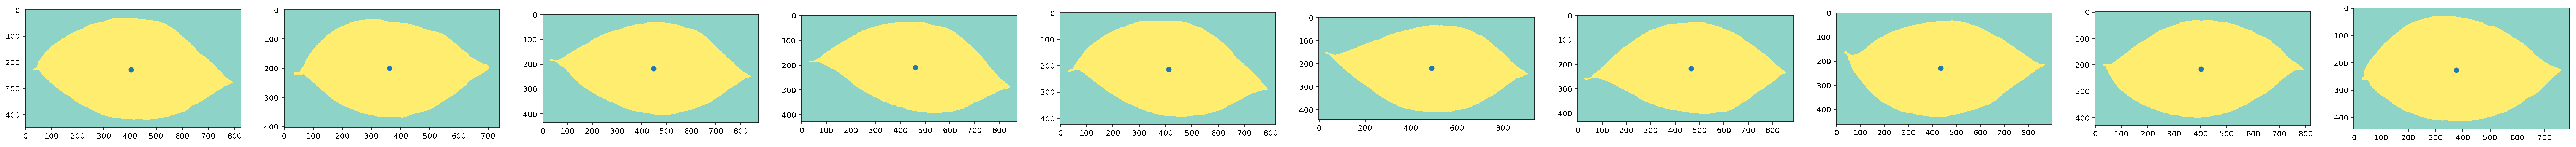

Testing Images: [ 200  480  909 1141 1489 1560]



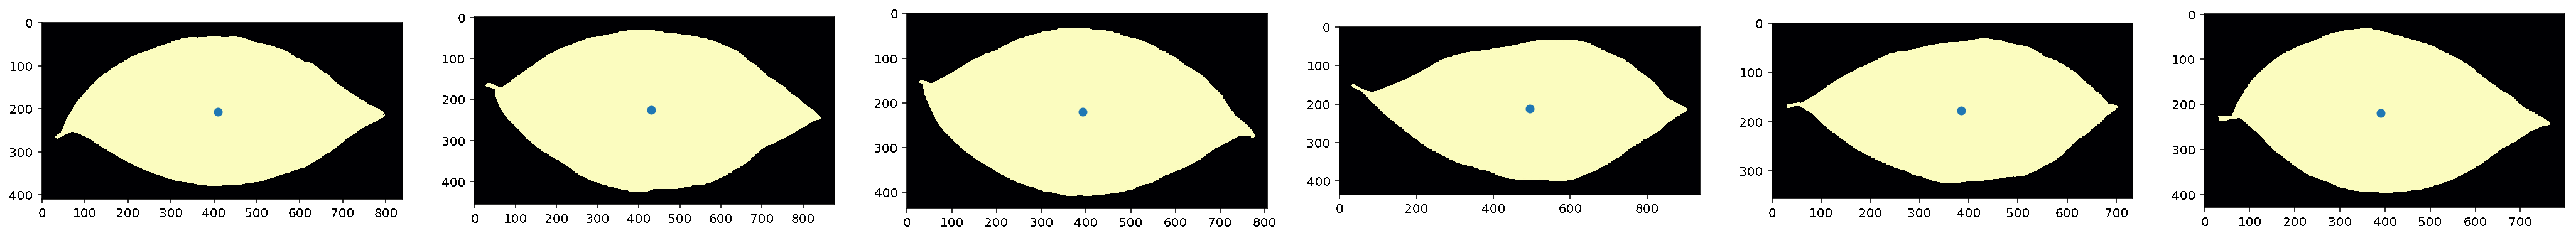

------------------------------Leaf Specie:Quercus_Alnifolia------------------------------
Training Images: [  75  133  508  728  849  861  958 1312 1374 1449]


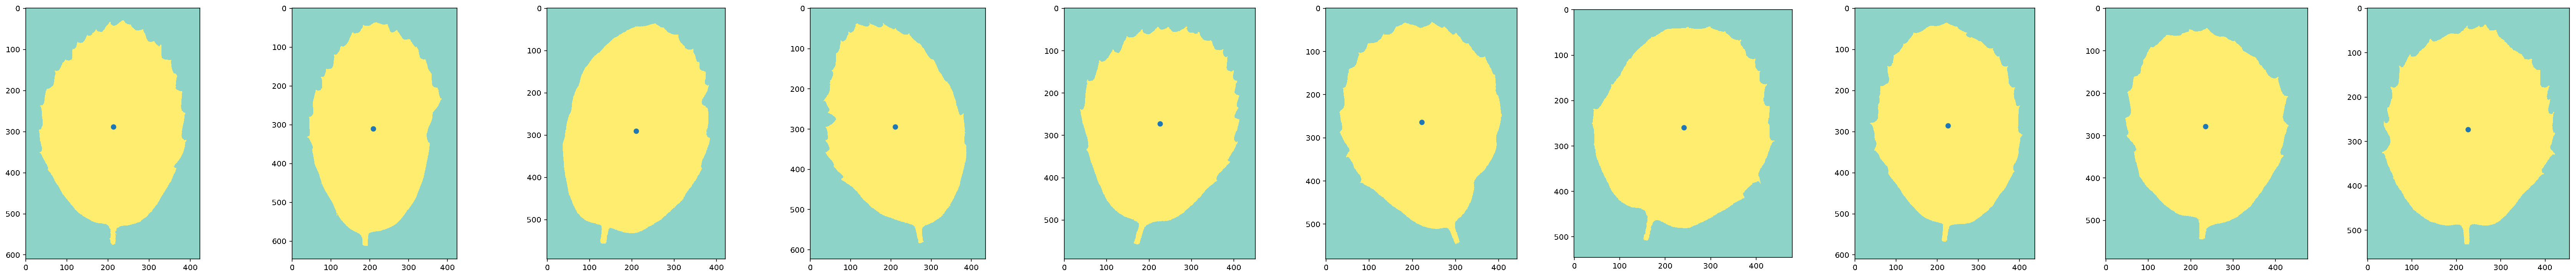

Testing Images: [  44  353  780  783 1193 1207]



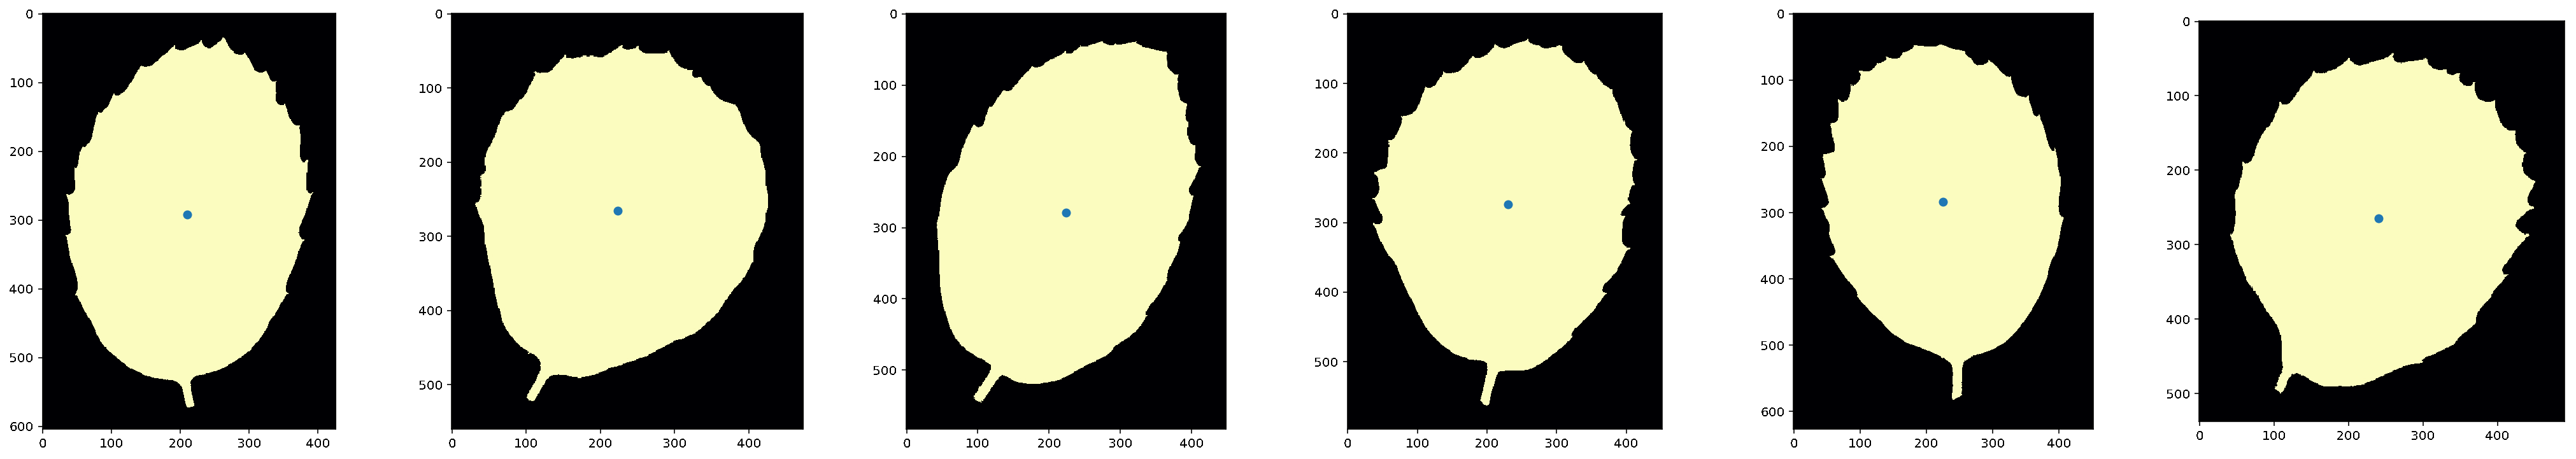

------------------------------Leaf Specie:Cercis_Siliquastrum------------------------------
Training Images: [  58   88  242  398  427  551  582  914 1094 1471]


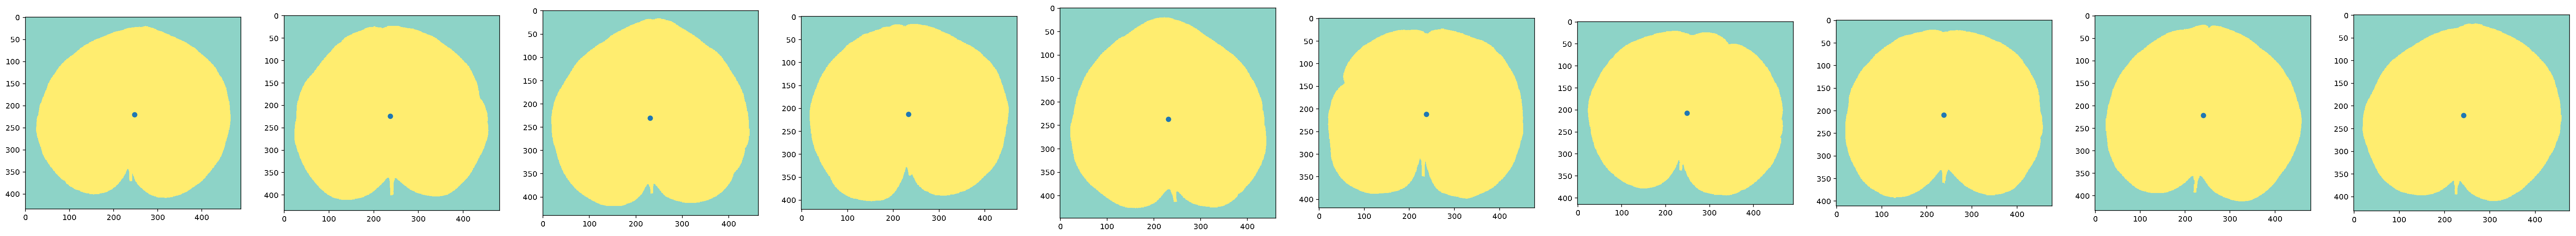

Testing Images: [ 147  210  432  439  744 1260]



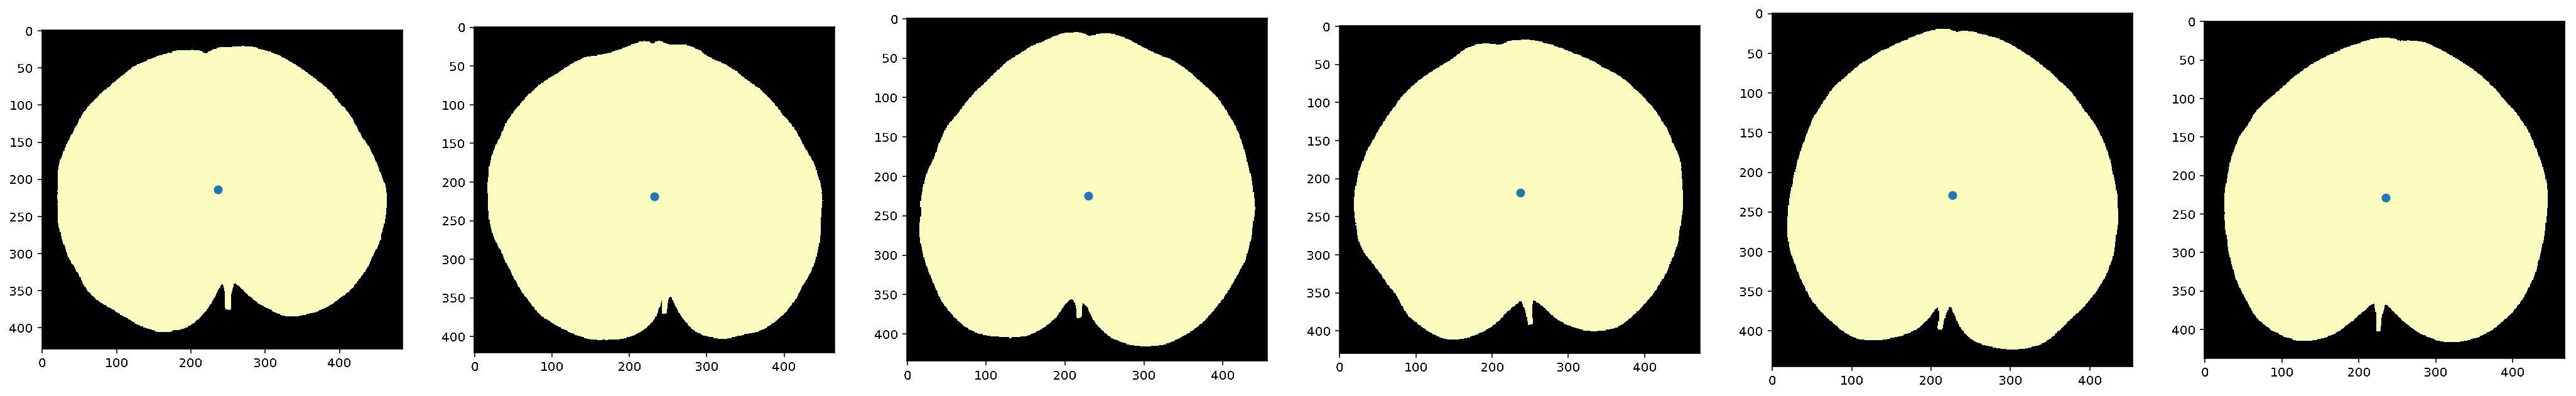

In [36]:
# check predictions
# SAMPLE_IDS=[201,160,216,1,27,146,38,238,148,78,186,140,55,34,334,37,18,339,73,425,61,58,42,71,217,60,218,49,56,173,265,25,116,155,106,124,48,149,233,214,8,304,342,26,30,237,188,81,80,2,21,142,75,14,10,228,165,168,22,163,63,270,101,344,82,3,35,263,664,67,485,130,127,40,20,29,72,375,11,108,355,83,109,31,6,323,345,225,54,15,522,676,107,183,5,436,291,152,17]
check_predictions(SAMPLE_IDS)

In [37]:
# check if all predicted species have 6 samples
pred_csv = '{}/test_pred.csv'.format(DATA_DIR)
pred_df = pd.read_csv(pred_csv, header=0)
pred_df = pred_df[['id', 'species']]
pivot = pred_df.pivot_table(index='species', values='id', aggfunc='count')
pivot[pivot != 6]

Series([], Name: id, dtype: int64)

------------------------------Leaf Specie:Quercus_x_Hispanica------------------------------
Training Images: [ 345  350  514  524  631  828 1375 1515 1548 1568]


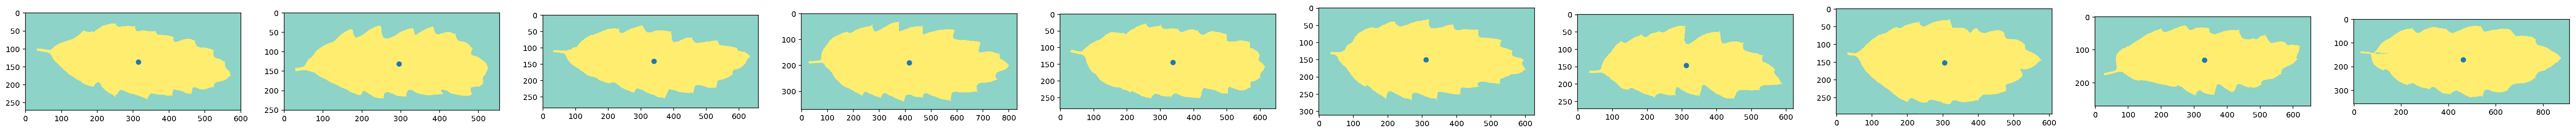

Testing Images: [ 131  347  384 1015 1191 1447]



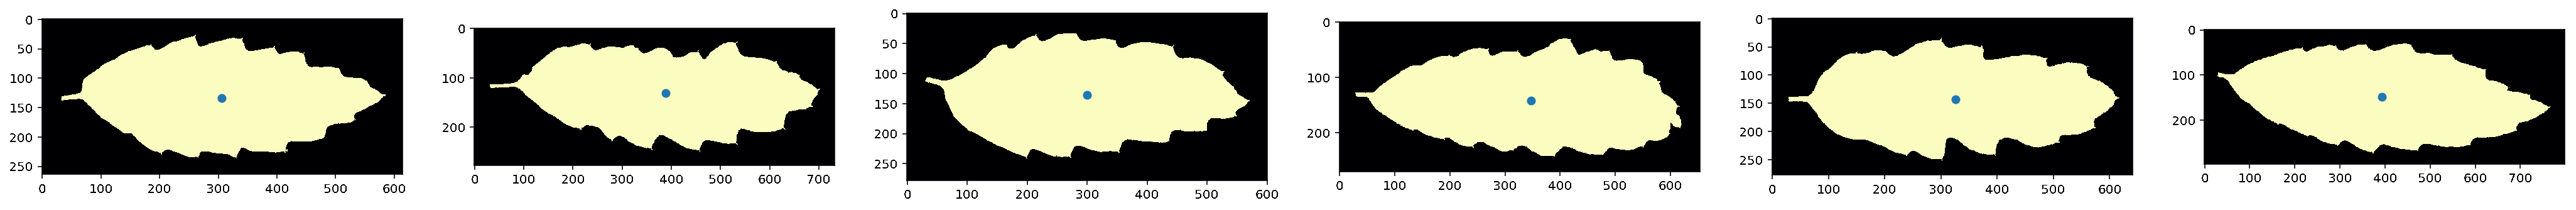

------------------------------Leaf Specie:Quercus_Kewensis------------------------------
Training Images: [  67  202  349  487  852  944  989 1168 1454 1529]


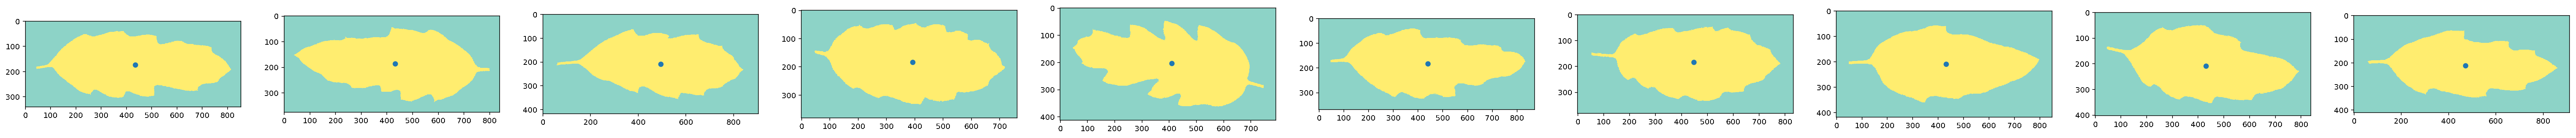

Testing Images: [ 414  725  739  988 1357 1382]



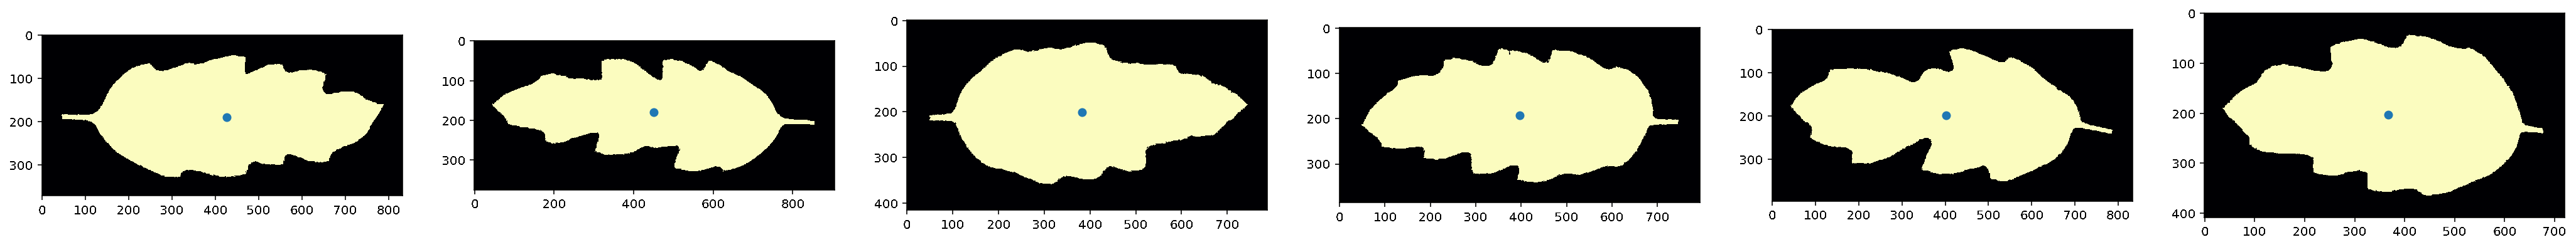

In [38]:
# list examples of leaf species with similarities
check_predictions([345, 487])

------------------------------Leaf Specie:Populus_Grandidentata------------------------------
Training Images: [ 237  388  440  530  561  694 1001 1223 1521 1545]


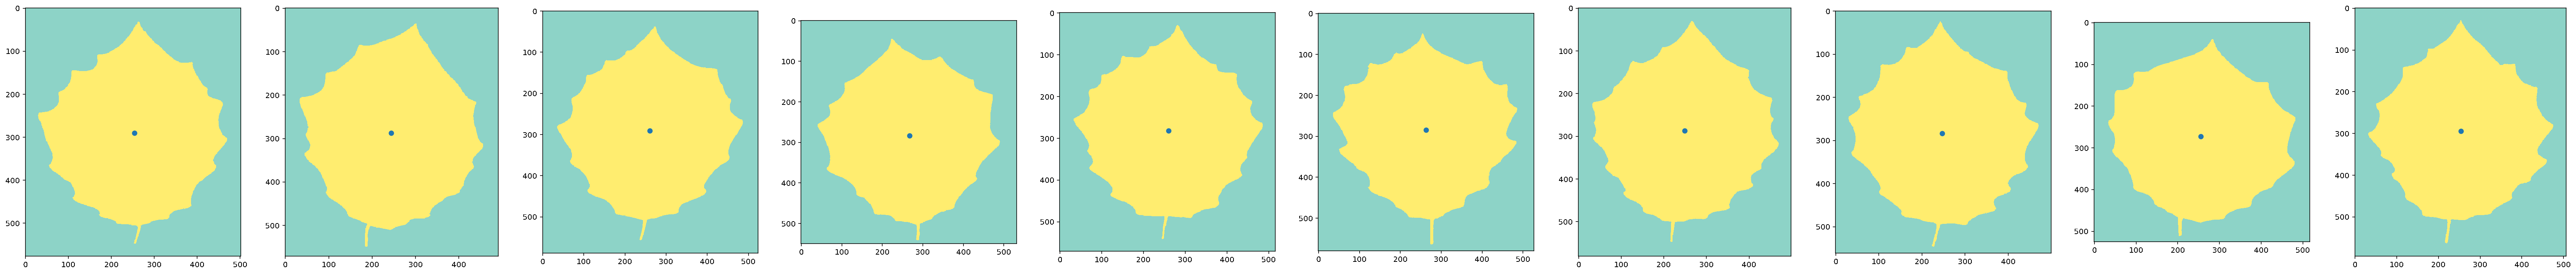

Testing Images: [  47  471  527  998 1224 1369]



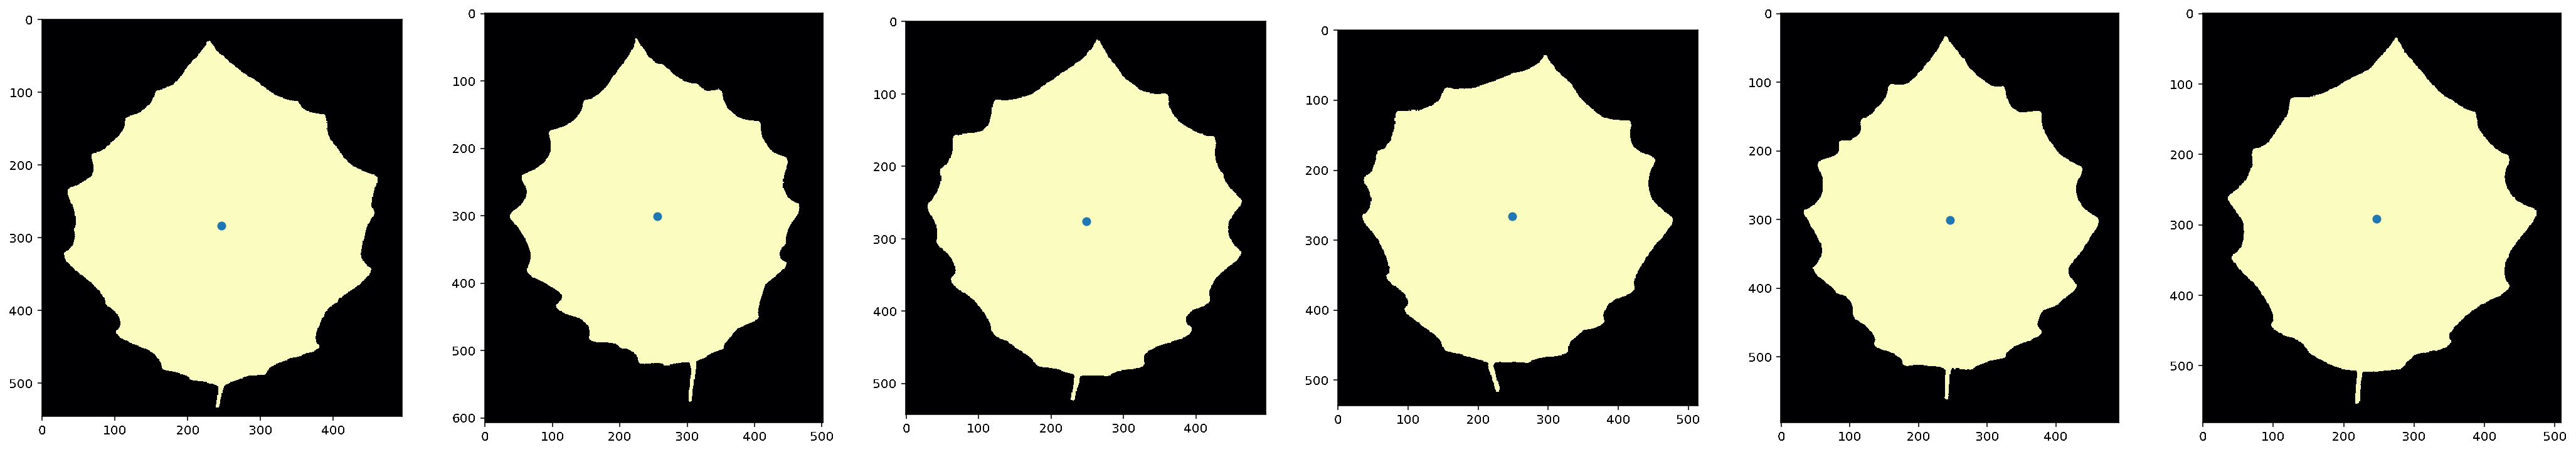

------------------------------Leaf Specie:Quercus_Semecarpifolia------------------------------
Training Images: [ 108  171  482  547  603  951 1010 1222 1359 1402]


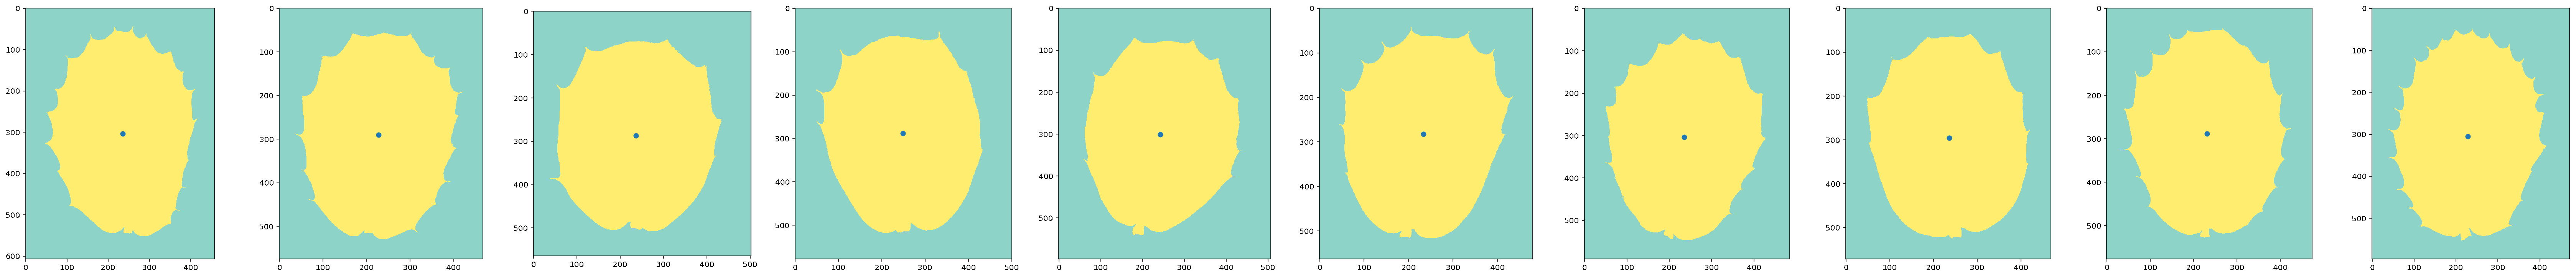

Testing Images: [ 405  407  594  690  947 1033]



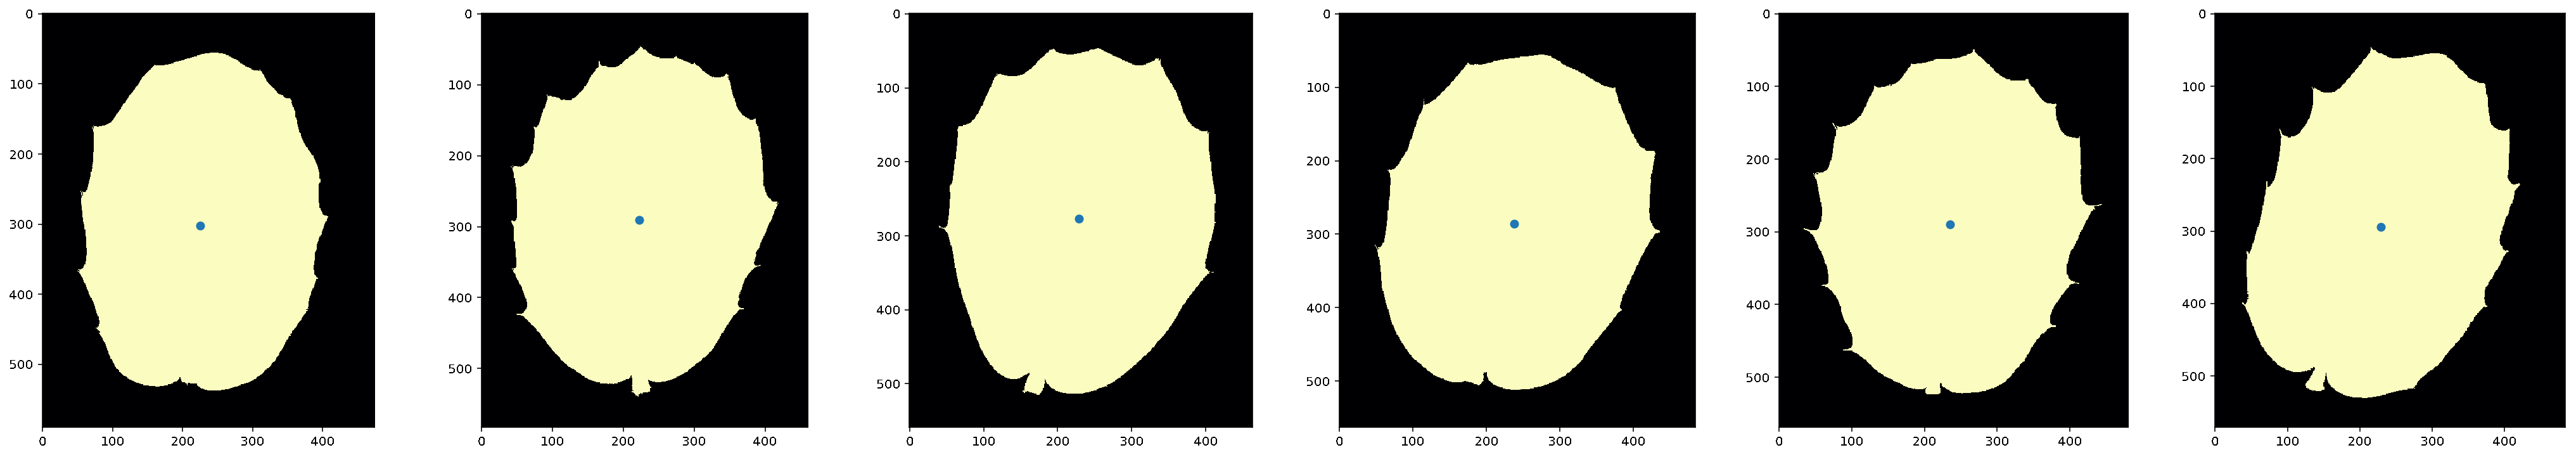

In [39]:
# list examples of leaf species with similarities
check_predictions([530, 547])

------------------------------Leaf Specie:Cornus_Controversa------------------------------
Training Images: [  71  273  614  757  881  932 1169 1345 1398 1527]


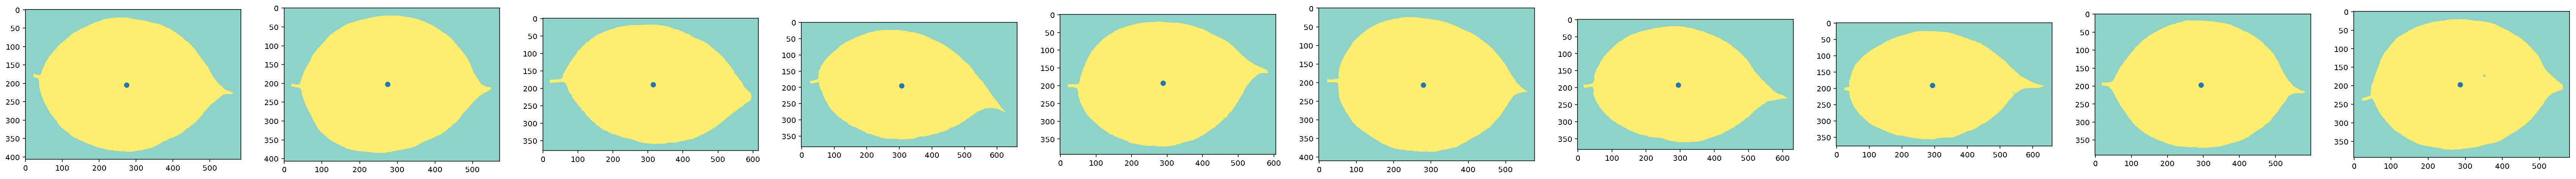

Testing Images: [ 114  195  300  477  743 1067]



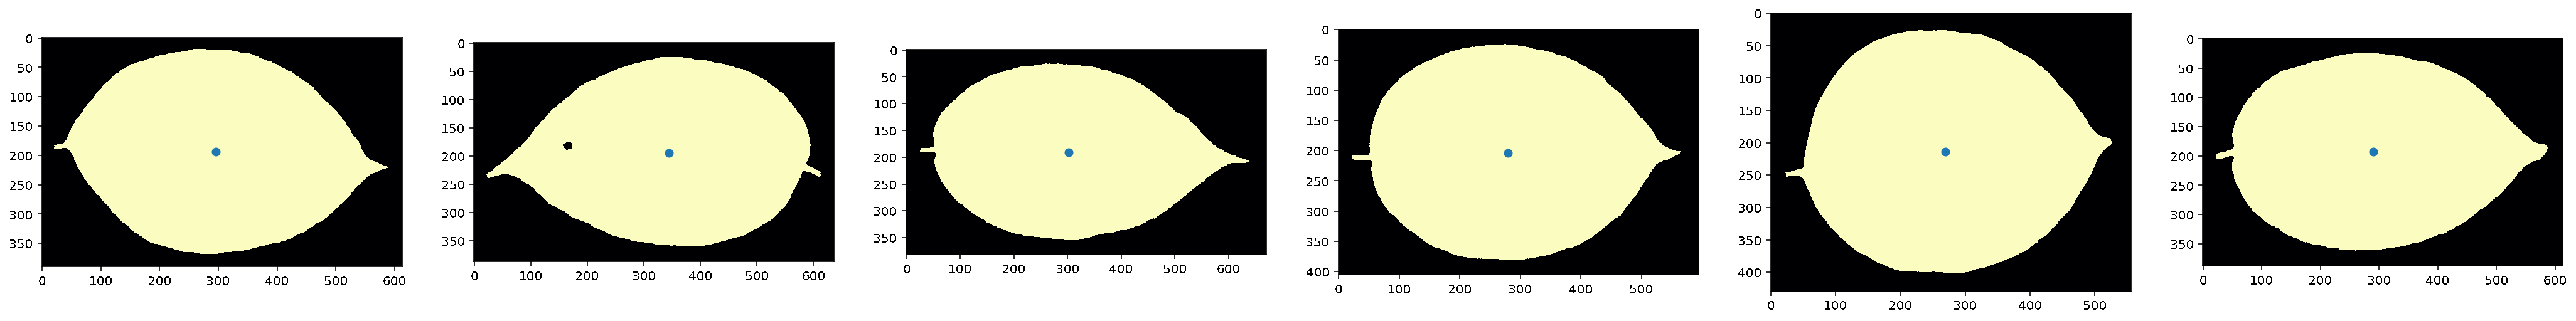

------------------------------Leaf Specie:Cornus_Macrophylla------------------------------
Training Images: [ 217  463  467  523  635  677  837  939  972 1208]


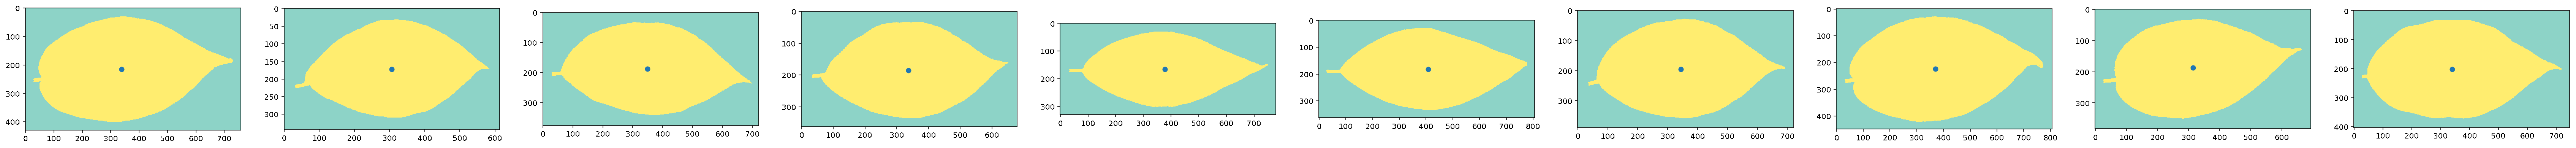

Testing Images: [ 191  301  313  782 1304 1351]



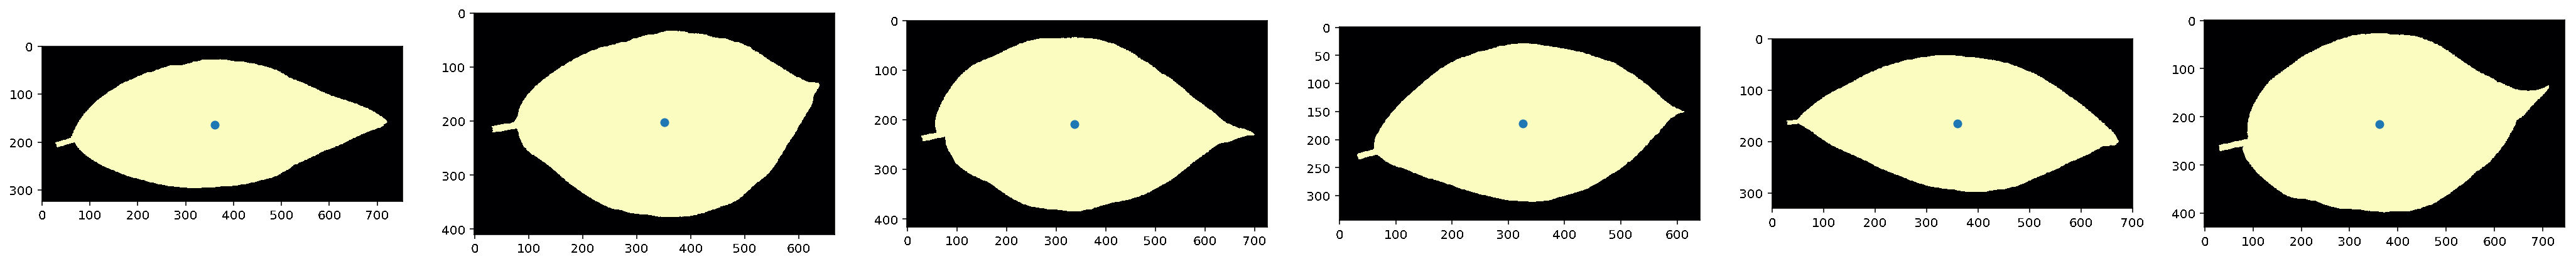

In [40]:
# list examples of leaf species with similarities
check_predictions([614, 635])

In [42]:
# =====================================
# visualize TF model using tensorboard
# src: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
# =====================================
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def write_graph_html(max_const_size=32):
    """print TensorFlow graph"""
    save_model_path = './model/model'
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as session:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(session, save_model_path)
        graph_def = loaded_graph.as_graph_def()
        strip_def = strip_consts(graph_def, max_const_size=max_const_size)
        code = """
        <html><body>
            <script>
              function load() {{
                document.getElementById("{id}").pbtxt = {data};
              }}
            </script>
            <link 
              rel="import" 
              href="https://tensorboard.appspot.com/tf-graph-basic.build.html" 
              onload=load()
            >
            <div style="height:600px">
              <tf-graph-basic id="{id}"></tf-graph-basic>
            </div>
        </body></html>
        """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
        with open('./model/model.html', 'w') as html:
            print(code, file=html)
        
write_graph_html()

INFO:tensorflow:Restoring parameters from ./model/model


## References:

* [TensorFlow - Python API](https://www.tensorflow.org/api_docs/python/)
* [TensorFlow - Deep Convolutional Neural Network](https://www.tensorflow.org/tutorials/deep_cnn)
* [TensorFlow - A Guide to TF Layers](https://www.tensorflow.org/tutorials/layers)
* [aymericdamien - TensorFlow Examples on Github](https://github.com/aymericdamien/TensorFlow-Examples)
* [Kaggle - Leaf Classification Competition - Image Features Extraction](https://www.kaggle.com/lorinc/feature-extraction-from-images-2)
* [Udacity - Machine Learning - Image Classification](https://www.udacity.com)

## Reproduction Environment

In [43]:
import IPython
print('Jupyter Env:\n{}'.format(IPython.sys_info()))

Jupyter Env:
{'commit_hash': '51ce9d73b',
 'commit_source': 'installation',
 'default_encoding': 'cp936',
 'ipython_path': 'C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\IPython',
 'ipython_version': '6.0.0',
 'os_name': 'nt',
 'platform': 'Windows-7-6.1.7601-SP1',
 'sys_executable': 'C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, '
                '21:28:42) [MSC v.1900 64 bit (AMD64)]'}


In [44]:
!pip freeze

alabaster==0.7.9
anaconda-client==1.6.0
anaconda-navigator==1.5
anaconda-project==0.4.1
astroid==1.4.9
astropy==1.3
Babel==2.3.4
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.5.3
bitarray==0.8.1
blaze==0.10.1
bokeh==0.12.4
boto==2.45.0
Bottleneck==1.2.0
cffi==1.9.1
chardet==2.3.0
chest==0.2.3
click==6.7
cloudpickle==0.2.2
clyent==1.2.2
colorama==0.3.7
comtypes==1.1.2
conda==4.3.14
configobj==5.0.6
contextlib2==0.5.4
cryptography==1.7.1
cycler==0.10.0
Cython==0.25.2
cytoolz==0.8.2
dask==0.13.0
datashape==0.5.4
decorator==4.0.11
dill==0.2.5
docutils==0.13.1
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==0.12
Flask-Cors==3.0.2
get==0.0.0
gevent==1.2.1
greenlet==0.4.11
h5py==2.6.0
HeapDict==1.0.0
hmmlearn==0.2.1
idna==2.2
imagesize==0.7.1
ipykernel==4.5.2
ipython==5.1.0
ipython-genutils==0.1.0
ipywidgets==5.2.2
isort==4.2.5
itsdangerous==0.24
jdcal==1.3
jedi==0.9.0
Jinja2==2.9.4
jsonschema==2.5.1
jupyter==1.0.0
jupyter-client==4.4.0
jupyter-console==5.0.0
jupyter-core==4.2.1
lazy-